# Facial Emotion Recognition

## Introduction

### Background

Emotional cues plays a crucial role in human communication. Some studies such as the one lead by [Dr Albert Meharabian](https://archive.org/details/silentmessagesim00mehr) noted that facial expression may have up to 55% of the impact to convey the message to the receiver. This importance is the reason why we prefer to talk face to face when discussion/ deciding an important matters even in the age of internet where call are cheap or even free. Interestingly, there are findings suggesting that human ability to 'detect' emotion varies across age and gender. For example, it is reported ([source1](https://academic.oup.com/psychsocgerontology/article/64B/6/696/552239?login=true), [source2](https://psycnet.apa.org/record/2007-03358-016)) in at least two studies that older adults are less perceptive of fear and anger in other people. It was also reported that ([source](https://www.frontiersin.org/articles/10.3389/fpsyg.2019.02371/full)) female at all age are a better emotion intepreter than their male counterparts. 

This introduces an issue at the digitalization era where human-computer interraction is more prevalent than ever. Robot can understand what we say, but that only captures 7% impact of what we actually mean, again quoting the famous study by [Dr Albert Meharabian](https://archive.org/details/silentmessagesim00mehr). Therefore, it is natural that the interest of Facial Emotion Recognition has recently spiked. One estimate suggests, the emotion recognition industry could worth to $37 billion by 2026 ([source](https://www.nature.com/articles/d41586-021-00868-5)). One of the use case, namely 4 Little Trees monitor children's emotion while they do classwork. It identifies students' facial features such as happy, sad, angry, disgust, surprise or fear to gauge their motivation and forecast grades ([source](https://www.4littletrees.com/)). Some other applications for facial emotion recognition are:
- Personal well-being monitoring system
- Customer Service performance monitoring
- Market research
- Video game testing

### Problem Statement

Motivated by the myriad application mentioned above, the aim of this study is to **build a model to identify emotion based on facial expression**. 

### Proposed Approach

Human naturally learns to recognize emotion based on the **facial landmarks** of the adults around us. This makes recognizing emotion a second nature to us. However, this is not as straightforward for computer as there are so many types of faces, skin tone and expression that prevents a hard-coded machine to perform as well as human. 

This opens up an opportunity for machine learning, specifically **Convolution Neural Network (CNN)** to enable machine to 'understand' facial emotion. The model will 'learn' the pattern of human emotion based on a collection of facial pictures labelled based on their corresponding emotion. Once the model has been trained, it will be deployed to some pictures and videos for testing. 

Overall, the **flow of work** is as follows:
1. Find facial emotion dataset
2. Explore the dataset
3. Select existing (pretrained) model(s) to perform emotion recognition on the dataset and tune it
4. Build a CNN model and tune it
5. Compare models to obtain the best model
6. Try out the best model againts pictures and videos

### List of Content

- [1. Introduction](#Introduction)
    - [1.1. Background](#Background)
    - [1.2. Problem Statement](#Problem-Statement)
    - [1.3. Proposed Approach](#Proposed-Approach)
    - [1.4. List of Content](#List-of-Content)
    - [1.5. Import Packages and Data](#Import-Packages-and-Data)
- [2. Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [2.1. View Pictures](#View-Pictures)
- [3. Baseline Model](#Baseline-Model)
- [4. Pretrained Model](#Pretrained-Model)
    - [4.1. VGG16](#VGG16)
    - [4.2. VGGFace](#VGGFace)
    - [4.3. ResNet50](#ResNet50)
- [5. Custom Model](#Custom-Model)
    - [5.1. Custom Model 1](#Custom-Model-1)
    - [5.2. Custom Model 2](#Custom-Model-2)    
    - [5.3. Custom Model 3](#Keras-Tuner)    
- [6. Summary of Model Training](#Summary-of-Model-Training)

### Import Packages and Data

In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import keras
from glob import glob
import os
from sklearn.metrics import confusion_matrix
import itertools
import pickle
from matplotlib.ticker import MaxNLocator
import operator
from decimal import Decimal
from sklearn.model_selection import train_test_split

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

tf.random.set_seed(42)
show_pic=True

The dataset for this study is provided by [Kaggle](https://www.kaggle.com/mahmoudima/mma-facial-expression). It contains 3 folders, train, validation and test sets. Within them, there are 7 more folders containing pictures of faces for each emotion, i.e. happy, sad, fear, disgusted, neutral, surprise and angry. We will capture the location of each pictures and put them in a dataframe.

In [7]:
# for MMA Dataset
dataset_path = os.getcwd() + '/dataset'
try:
    data = pd.read_csv(dataset_path + '/data.csv')
except IOError:
    print("No data file found. Creating one.")
    ## Collect all path in the folder
    image_paths = glob(os.path.join(dataset_path, '*', '*', '*', '*'))

    ## Create a dataframe containing complete path, dataset, label and filename
    data = pd.DataFrame(image_paths, columns = ['complete_path'])
    data['dataset'] = data.apply(lambda x: x['complete_path'].split('/')[11], axis=1)
    data['label'] = data.apply(lambda x: x['complete_path'].split('/')[12], axis=1)
    data['label'] = data['label'].map(lambda x: x.split('_')[0])
    data['filename'] = data.apply(lambda x: x['complete_path'].split('/')[14], axis=1)
    data.to_csv(dataset_path + '/data.csv')

data.head(5)

No data file found. Creating one.


complete_path dataset label  \
0  /Users/jeffersonqiu/Desktop/General_Assembly/D...   valid  fear   
1  /Users/jeffersonqiu/Desktop/General_Assembly/D...   valid  fear   
2  /Users/jeffersonqiu/Desktop/General_Assembly/D...   valid  fear   
3  /Users/jeffersonqiu/Desktop/General_Assembly/D...   valid  fear   
4  /Users/jeffersonqiu/Desktop/General_Assembly/D...   valid  fear   

                        filename  
0  8971Exp2fighting_face_555.jpg  
1                 Fear.30570.jpg  
2                 Fear.29021.jpg  
3                 Fear.29753.jpg  
4                 Fear.30564.jpg

## Exploratory Data Analysis

In [12]:
data.dataset.value_counts()

train    92968
test     17356
valid    17356
Name: dataset, dtype: int64

In [8]:
data.label.value_counts()

neutral     41081
happy       39526
sad         16636
surprise    11062
angry        8624
fear         6209
disgust      4542
Name: label, dtype: int64

There are total of 126k pictures on training (93k), validation (17k) and test (17k). Most pictures in the set is from neutral and happy faces. The rarest emotion in the dataset is disgust. For the purpose of this study, we will only use training and validation set. Therefore, we will split them up into different dataframe.

In [9]:
# Split the DataFrame to Train and Validation
train_df = data[data['dataset'] == 'train']
train_df = train_df.sample(frac=1, random_state=41).reset_index(drop=True)
valid_df = data[data['dataset'] == 'test']
valid_df = valid_df.sample(frac=1, random_state=41).reset_index(drop=True)

In [13]:
train_df.label.value_counts(normalize=True)

neutral     0.316066
happy       0.307547
sad         0.131475
surprise    0.087267
angry       0.070626
fear        0.052265
disgust     0.034754
Name: label, dtype: float64

In [14]:
valid_df.label.value_counts(normalize=True)

neutral     0.337520
happy       0.314531
sad         0.125432
surprise    0.084985
angry       0.059979
fear        0.039813
disgust     0.037739
Name: label, dtype: float64

Both training and validation set has similar spread of each class with the majority class of neutral, closely followed by happy at above 30% of picture counts. the smallest class is disgust with about 3% of total picture counts.

### View Pictures

Let us view the picture provided for each emotion.

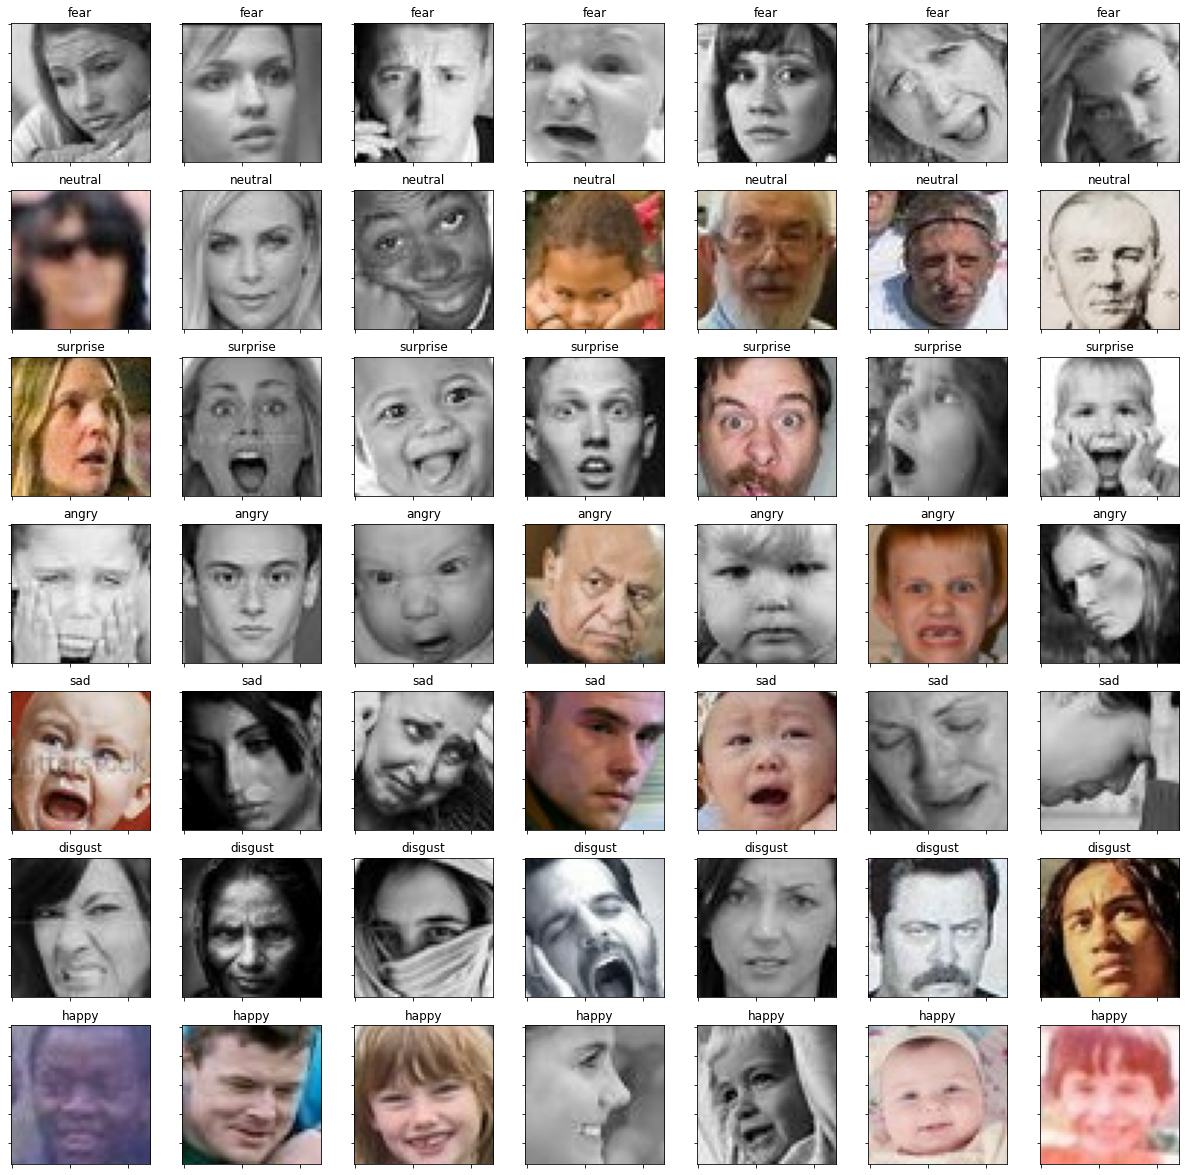

In [11]:
# Observe the data 

if show_pic:
    num_pics_per_class = 7
    num_of_classes = data.label.nunique()
    classes = list(data.label.unique())

    fig, ax = plt.subplots(nrows=num_of_classes, ncols=num_pics_per_class, figsize=(21, 3*num_of_classes))
    ax=ax.ravel()
    for row_no, label in enumerate(classes):
        for i in range(num_pics_per_class):
            try:
                image = train_df[train_df['label']==label].iloc[i].complete_path
            except:
                print(label, i)
            image_string = tf.io.read_file(image)
            image_decoded = tf.image.decode_jpeg(image_string, channels=3)
            axis = i + row_no * num_pics_per_class
            ax[axis].set_title(label)
            ax[axis].imshow(image_decoded)
            ax[axis].set_xticklabels('')
            ax[axis].set_yticklabels('')
    plt.tight_layout
    plt.show();

**Observations:**
- As we can see, some of the emotion are easier to recognize than the other. For example, **fear** faces tend to look a bit sad  or angry while **disgust** picture some looks angry. 
- Compare this with happy or sad face where the emotion are more obvious with less ambiguity and subjectivity involves. 

This is inline with the emotion quadrant introduced by Fei Yan, et al. ([source](https://www.researchgate.net/figure/Modified-PA-plane-with-four-emotional-quadrants_fig2_335191634)) which divides human emotion into four different areas on a Cartesian Quadrant where some emotion are indeed 'closer' or more 'similar' to one another then other emotions. 

![emotion_quadrant.png](./media/emotion_quadrant.png)

To avoid problem of ambiguity and reduce the impact of training picture label subjectivity, we will only use emotion with the biggest difference, i.e. happy, sad and angry at the corner of the quadrant. Note here that currently we do not find 'relaxed' dataset as the extreme end of quadrant 'Calm'. Therefore, it will be left for further study. 

In [15]:
# Select category to include 
class_to_include = ['happy', 'sad', 'angry']
# class_to_include = data['label'].unique()

train_df = train_df[train_df['label'].isin(class_to_include)]
valid_df = valid_df[valid_df['label'].isin(class_to_include)]

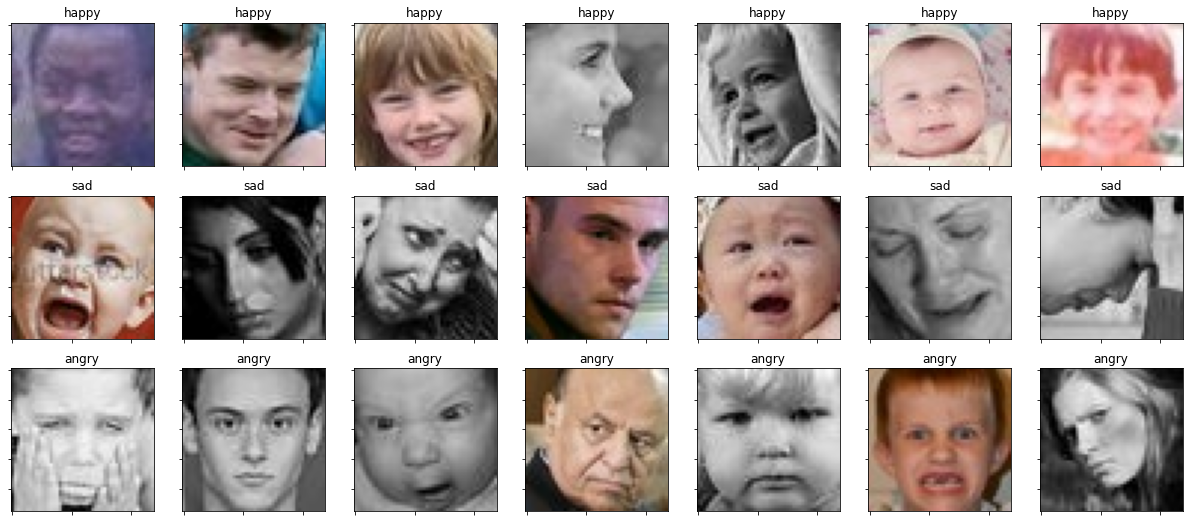

In [16]:
# Observe the data 

if show_pic:
    num_pics_per_class = 7
    num_of_classes = len(class_to_include)

    fig, ax = plt.subplots(nrows=num_of_classes, ncols=num_pics_per_class, figsize=(21, 3*num_of_classes))
    ax=ax.ravel()
    for row_no, label in enumerate(class_to_include):
        for i in range(num_pics_per_class):
            image = train_df[train_df['label']==label].iloc[i].complete_path
            image_string = tf.io.read_file(image)
            image_decoded = tf.image.decode_jpeg(image_string, channels=3)
            axis = i + row_no * num_pics_per_class
            ax[axis].set_title(label)
            ax[axis].imshow(image_decoded)
            ax[axis].set_xticklabels('')
            ax[axis].set_yticklabels('')
    plt.tight_layout
    plt.show();

In [17]:
# Create conversion from label to integer class
label_to_class = dict((key, value) for value, key in enumerate(sorted(train_df.label.unique())))
label_to_class

{'angry': 0, 'happy': 1, 'sad': 2}

In [18]:
class_to_label = dict((key, value) for key, value in enumerate(sorted(train_df.label.unique())))
class_to_label

{0: 'angry', 1: 'happy', 2: 'sad'}

In [19]:
# Convert the label to integer class and imputed it into the dataframe
def converter(string, label_to_class):
    switcher = label_to_class
    return switcher.get(string, "Invalid class")

train_df['class'] = train_df.apply(lambda x: converter(x['label'], label_to_class), axis=1)
valid_df['class'] = valid_df.apply(lambda x: converter(x['label'], label_to_class), axis=1)
train_df.head(2)

complete_path dataset  label  \
2  /Users/jeffersonqiu/Desktop/General_Assembly/D...   train  happy   
3  /Users/jeffersonqiu/Desktop/General_Assembly/D...   train    sad   

                            filename  class  
2  77340Exp3astound_european_823.jpg      1  
3     36965Exp4crying_infant_250.jpg      2

The training dataset spread between the three classes of emotions:

In [12]:
train_df.label.value_counts()

happy    28592
sad      12223
angry     6566
Name: label, dtype: int64

In [21]:
def limiter_function(df):
    num_min = min(df.label.value_counts())
    min_label = df.groupby('label')['label'].max()[df.groupby('label')['filename'].count() == num_min]
    labels_to_limit = [x for x in class_to_include if x not in min_label]

    balanced_df = pd.DataFrame()

    for label in labels_to_limit:
        balanced_df = pd.concat([df[df['label']==label].sample(n=num_min), balanced_df])

    balanced_df = pd.concat([balanced_df, df[df['label']==min_label.values[0]]])
    balanced_df.sort_index(inplace=True)
    balanced_df.label.value_counts()
    return balanced_df

As seen previously, we have imbalanced class on our training and validation dataset. Therefore, we may have an issue of the model not learning enough on the minority class. To combat this issue, a few ways we can explore:
1. Create artificial pictures on minority class until it reaches majority class count. This can be done by data augmentation performed by rotating, resizing, shifting or flipping the pictures to make a new different picture. 
2. Limit the majority class count based on minority class count. This is done by randomly chosing the picture from majority class without replacement until we reach minority class count.

As the training set is significant, we will attempt to go with the second way to overcome the long training time. If we cannot get a satisfactory result on our model, we will adjust the strategy again accordingly. 

In [22]:
train_balanced_df = limiter_function(train_df)
valid_balanced_df = limiter_function(valid_df)

In [23]:
train_balanced_df.label.value_counts()

happy    6566
sad      6566
angry    6566
Name: label, dtype: int64

In [24]:
# Create a constant for filanames and label to construct the dataset
train_filenames_list = train_balanced_df['complete_path'].tolist()
train_filenames = tf.constant(train_filenames_list)
train_labels_list = train_balanced_df["class"].tolist()
train_labels = tf.constant(train_labels_list)

valid_filenames_list = valid_balanced_df['complete_path'].tolist()
valid_filenames = tf.constant(valid_filenames_list)
valid_labels_list = valid_balanced_df["class"].tolist()
valid_labels = tf.constant(valid_labels_list)

In [25]:
# Create function to read the image from the file, decodes it into a tensor, and resizes it to a fixed shape.
img_rows = 48
img_cols = 48
num_of_classes = len(class_to_include)
batch_size = 32

def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
    if num_of_classes == 2:
        label = tf.one_hot(label, num_of_classes)[0]
    else:
        label = tf.one_hot(label, num_of_classes)
    return image_resized, label

# Create function to generate the dataset
def dataset_generator(filenames, labels):
    return tf.data.Dataset.from_tensor_slices((filenames, labels)).map(_parse_function).batch(batch_size)

## Construct the dataset
train_dataset = dataset_generator(train_filenames, train_labels)
valid_dataset = dataset_generator(valid_filenames, valid_labels)

Once again, this is done to fasten the training speed to find the best model with reasonable amount of training hours. 

In [26]:
# Create mini batches to make it faster to do learning
train_batches = tf.data.experimental.cardinality(train_dataset)
train_ds = train_dataset.take(train_batches//2)
valid_batches = tf.data.experimental.cardinality(valid_dataset)
valid_ds = valid_dataset.take(valid_batches//15)

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of val batches: %d' % tf.data.experimental.cardinality(valid_ds))

Number of train batches: 308
Number of val batches: 6


## Baseline Model

The simplest model we can have is to predict all the dataset based on the category with the highest frequency. This 'dumb' model at least can be as accurate as the frequency of biggest class. Therefore, subsequent models aim to reach an accuracy level at least higher than this of the basic model. 

In [27]:
valid_balanced_df.label.value_counts()

sad      1041
angry    1041
happy    1041
Name: label, dtype: int64

In [28]:
print("Accuracy to beat: {}%.".format(round(valid_balanced_df['label'].value_counts(normalize=True).sort_values(ascending=False)[0]*100,1)))

Accuracy to beat: 33.3%.


## Pretrained Model

Pretrained models is actually an existing CNN model trained on other dataset. It should be able to detect some key features such as lines or shape well but not necessary good in generalizing to the existing data. Therefore, we will perform double training, i.e. baseline and fine tuning training. During baseline training, the CNN model will go through a few epochs to train the fully connected dense layers, subsequently, a more thorough training with more epochs is done (fine tuning) on more layers, including a few final layers within the pretrained model. 

### VGG16

As a start, a simple model is chosen to gauge its capability in identifying different emotions. VGG16 was proposed by K. Simonyan and A. Zisserman from University of Oxford ([source](https://neurohive.io/en/popular-networks/vgg16/)) and famous as it made some improvement over AlexNet by replacing bigger sized filters (11x11 and 5x5) to a smaller ones (3x3). This is suitable for our model as the MMA Facial Emotion Recognition dataset from Kaggle only consists of 48x48 sized pictures. 

#### Baseline Model

In [170]:
# Base model
## Import the Base Model 
from tensorflow.keras.applications import VGG16

## Instantiate the Base Model
base_model_vgg16 = tf.keras.applications.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    include_top=False,   # Do not include the ImageNet classifier at the top.
    pooling='avg',
    input_shape=(48, 48, 3)
) 
## Freeze the base_model
base_model_vgg16.trainable = False

## Print model summary
base_model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [33]:
# Build the model
## Othery layers on top of the Base Model
dense_layer_1 = tf.keras.layers.Dense(64, kernel_initializer='lecun_normal', name='dense_layer_1', activation='selu')
dropout_layer_1 = tf.keras.layers.AlphaDropout(0.5, name='dropout_layer_1')
dense_layer_2 = tf.keras.layers.Dense(16, kernel_initializer='lecun_normal', name='dense_layer_2', activation='selu')
dropout_layer_2 = tf.keras.layers.AlphaDropout(0.5, name='dropout_layer_2')
if num_of_classes == 2:
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='prediction_layer')
else:
    prediction_layer = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='prediction_layer')

## Define the model flow
inputs = tf.keras.Input(shape=(48, 48, 3), name='input_layer')
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model_vgg16(x, training=False)
x = dense_layer_1(x)
x = dropout_layer_1(x)
x = dense_layer_2(x)
x = dropout_layer_2(x)
outputs = prediction_layer(x)
model_vgg16 = tf.keras.Model(inputs, outputs)

model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_layer_1 (Dense)        (None, 64)                32832     
_________________________________________________________________
dropout_layer_1 (AlphaDropou (None, 64)                0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 16)                1040  

In [34]:
# Create a dictionary to keep all the model fitting histories
history = dict()

In [35]:
base_learning_rate = 0.001

if num_of_classes == 2:
    model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
else:
    model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

initial_epochs = 10
history['VGG16'] =  model_vgg16.fit(train_ds, 
                                  validation_data=valid_ds, 
                                  epochs=initial_epochs, 
                                  verbose=1)

Epoch 1/10
308/308 [==============================] - 23s 75ms/step - loss: 1.4693 - accuracy: 0.3722 - val_loss: 1.0493 - val_accuracy: 0.4531
Epoch 2/10
308/308 [==============================] - 24s 77ms/step - loss: 1.0638 - accuracy: 0.4320 - val_loss: 1.1823 - val_accuracy: 0.4062
Epoch 3/10
308/308 [==============================] - 23s 74ms/step - loss: 1.0375 - accuracy: 0.4599 - val_loss: 1.2119 - val_accuracy: 0.4167
Epoch 4/10
308/308 [==============================] - 23s 74ms/step - loss: 1.0206 - accuracy: 0.4849 - val_loss: 1.1958 - val_accuracy: 0.4323
Epoch 5/10
308/308 [==============================] - 23s 75ms/step - loss: 1.0037 - accuracy: 0.4915 - val_loss: 1.2284 - val_accuracy: 0.4427
Epoch 6/10
308/308 [==============================] - 24s 77ms/step - loss: 0.9849 - accuracy: 0.5082 - val_loss: 1.3126 - val_accuracy: 0.4531
Epoch 7/10
308/308 [==============================] - 23s 75ms/step - loss: 0.9837 - accuracy: 0.5215 - val_loss: 1.2943 - val_accuracy:

##### Performance Review

In [37]:
def accuracy_loss_plotter(model_name, train_accuracy, valid_accuracy, train_loss, valid_loss, fine_tune_at=None):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5));

    min_accuracy = min(train_accuracy + valid_accuracy)
    max_accuracy = max(train_accuracy + valid_accuracy)
    min_loss = min(train_loss + valid_loss)
    max_loss = max(train_loss + valid_loss)

    if fine_tune_at == None:
        pass
    else:
        ax[0].vlines(fine_tune_at, ymin=min_accuracy, ymax=max_accuracy, label='Start of Fine Tuning')
        ax[1].vlines(fine_tune_at, ymin=min_loss, ymax=max_loss, label='Start of Fine Tuning')

    # Generate line plot of training, testing loss over epochs.
    ax[0].plot(train_accuracy, label='Training Accuracy', color='#185fad')
    ax[0].plot(valid_accuracy, label='Validation Accuracy', color='red')
    ax[0].set_title('Training and Vaidation Accuracy', fontsize = 18)
    ax[0].set_xlabel('Epoch', fontsize = 18)
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].legend(fontsize = 12)

    # Generate line plot of training, testing loss over epochs.
    ax[1].plot(train_loss, label='Training Loss', color='#185fad')
    ax[1].plot(valid_loss, label='Validation Loss', color='red')
    ax[1].set_title('Training and Vaidation Loss', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 18)
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].legend(fontsize = 12)

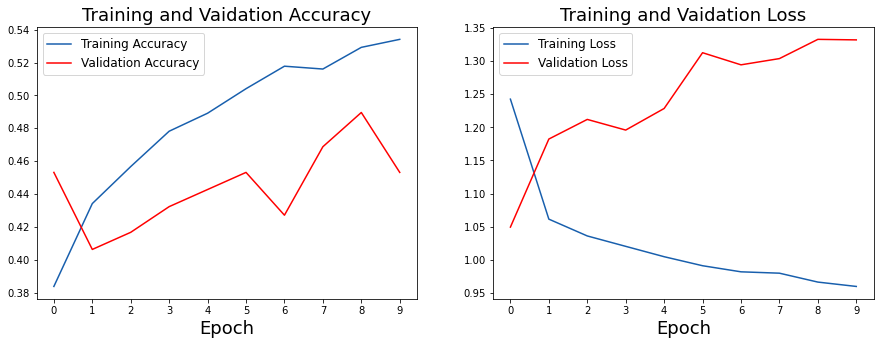

In [38]:
train_acc = history['VGG16'].history['accuracy']
valid_acc = history['VGG16'].history['val_accuracy']
train_loss = history['VGG16'].history['loss']
valid_loss = history['VGG16'].history['val_loss']

accuracy_loss_plotter('VGG16', train_acc, valid_acc, train_loss, valid_loss)

**Observations:**

- In the first 10 epochs, we can see that the model is generalizing pretty well as the training and validation accuracy goes hand in hand. 
- The model goes to the 'right' direction as accuracy increases while loss decreases for both training and validation dataset. 

However, although accuracy and loss data per epochs provides us the overall overview on how our model is performing, it fails to capture the details such as which category is misclassified the most or the type of picture has higher chances to be misclassfied. Therefore, a few functions will be defined to serve this purpose:

| Functions                | Input                                                                 | Output                                                                                       | Purpose                                                                                                                             |
|:--------------------------|:-----------------------------------------------------------------------|:----------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| cm_generator             | - model object<br>- dataset<br>- no of batches to generate the output | Confusion Matrix                                                                             | To provide insight on which category being misclassified the most to which category<br>(the function is called in plot_cm function) |
| plot_cm                  | - confusion matrix<br>- number of classes                             | Plotted confusion matrix                                                                     | To plot the confusion matrix created earlier by cm_generator                                                                        |
| comparator_general       | - model object<br>- dataset<br>- no of batches to generate the output | A dataframe containing:<br>- image data (numpy array)<br>- actual label<br>- predicted label | To provide insight on which type of pictures being misclassified<br>(the function is called in wrong_prediction_plotter function)   |
| wrong_prediction_plotter | - model object<br>- dataset<br>- predicted label to observe           | Plot misclassified pictures per predicted label                                              | To observe closer which type of pictures being misclassified to each of other class                                                 |

In [39]:
# Define functions to analyse the result of models

def cm_generator(model, ds, no_of_batches):
    preds = np.argmax(model.predict(ds.take(no_of_batches)), axis=1)
    actual = list()
    for img, label in ds.take(no_of_batches):
        actual.append(np.argmax(label, axis=1))
    return confusion_matrix(actual[0], preds)

def plot_cm(cm, classes,
            normalize=False,
            title='Confusion matrix',
            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def comparator_general(model, ds, no_of_batches):
    preds = np.argmax(model.predict(ds.take(no_of_batches)), axis=1)
    actual = list()
    img_list = list()
    for img, label in ds.take(no_of_batches):
        actual.append(np.argmax(label, axis=1))
        img_list.append(img)
    combined_df =  pd.concat([pd.Series(preds), pd.Series(actual[0])], axis=1).rename(columns={0:'pred', 1:'actual'})
    combined_df['diff'] = combined_df.apply(lambda x: x['pred']!=x['actual'], axis=1)
    combined_df['pred_label'] = combined_df.apply(lambda x: class_to_label[x['pred']], axis=1)
    combined_df['actual_label'] = combined_df.apply(lambda x: class_to_label[x['actual']], axis=1)
    img_list = img_list[0].numpy()
    return combined_df, img_list
  
def wrong_prediction_plotter(model, ds, predicted):
    print("Predicted as {}:".format(predicted));
    x, img = comparator_general(model, ds, 1)

    y = x[(x['diff']==True) & (x['pred_label']==predicted)].sort_values(by='actual_label', ascending=True)

    n = len(y)
    if n == 0:
        print("No pictures wrongly predicted as {}".format(predicted))
    else:
        ncols = 7
        nrows = int(np.ceil(n/7))
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows), frameon=False)
        axs=axs.ravel()

        for i, index in enumerate(y.index):
            axs[i].imshow(tf.cast(img[index], 'uint8'))
            axs[i].set_title(str(i)+'. Actual: ' + y['actual_label'][index]);

        for ax in axs:
            ax.axis('off');

Once we defined all functions. Let's call one by one to observe the performance of the model.


Confusion matrix, without normalization


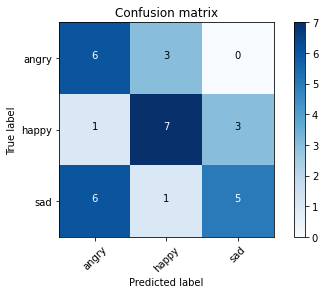

In [40]:
cm = cm_generator(model_vgg16, valid_ds, 1)
plot_cm(cm, label_to_class.keys())

Predicted as happy:


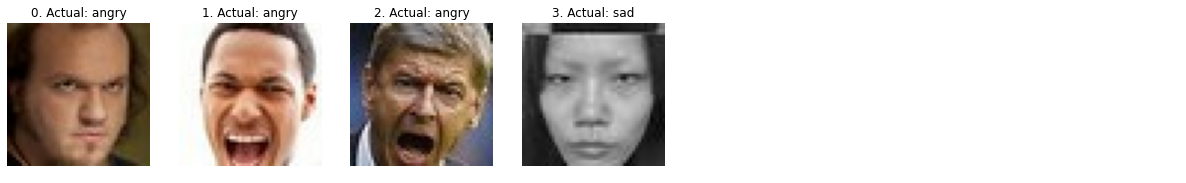

In [41]:
predicted='happy'
wrong_prediction_plotter(model_vgg16, valid_ds, predicted)

Predicted as sad:


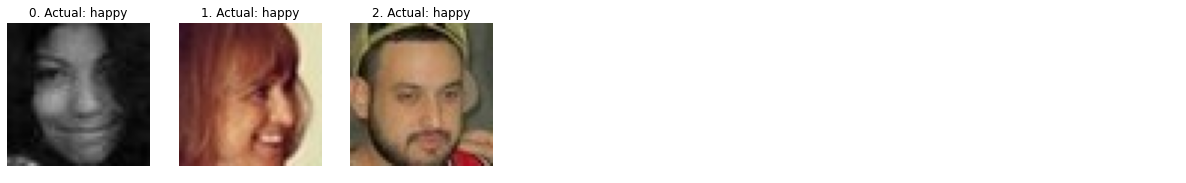

In [42]:
predicted='sad'
wrong_prediction_plotter(model_vgg16, valid_ds, predicted)

Predicted as angry:


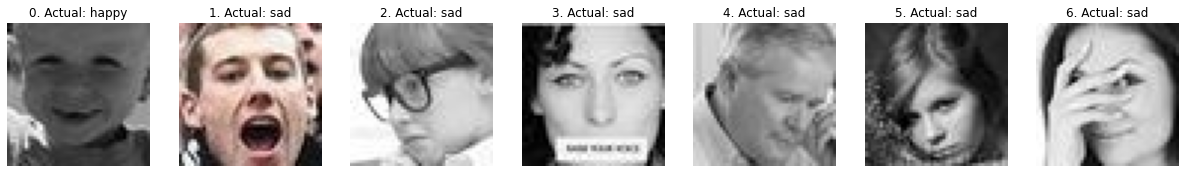

In [43]:
predicted='angry'
wrong_prediction_plotter(model_vgg16, valid_ds, predicted)

**Observations:**
- No happy face categorized into angry face while no sad face misclassified to be a happy face. This is a good sign and shows that the model is going to the right direction. 
- However, there are still many faces wrongly categorized especially on happy face classified into sad face.

#### Fine Tuning

Previously, we use VGG16 model built based on the weight of imagenet database. However, as our case requires specific implementation of CNN to classify emotions, we may need to retrain the last few layers of the model to suit our need better. Therefore, we will unfreeze some layers for this purpose. 

In [44]:
# check the total number of layers that VGG16 has
print("Total number of hidden layers: {}".format(len(base_model_vgg16.layers)))

Total number of hidden layers: 20


Let's unblock the last block of VGG16 CNN, i.e. block 5 from layer 15 onwards.

In [167]:
base_model_vgg16.trainable = True

# Fine-tune from this layer onwards 
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_vgg16.layers[:fine_tune_at]:
    layer.trainable =  False

In [46]:
if num_of_classes == 2:
    model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])
else:
    model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 48, 48, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_layer_1 (Dense)        (None, 64)                32832     
_________________________________________________________________
dropout_layer_1 (AlphaDropou (None, 64)                0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 16)                1040  

In [47]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                        patience = 3,verbose = 1,
                        factor = 0.50,
                        min_lr = 1e-10)

es = tf.keras.callbacks.EarlyStopping(verbose=1,
                                        monitor='val_accuracy',
                                        patience=6,
                                        min_delta=0.001,
                                        restore_best_weights=True)

mcp_path = './saved_models/model_vgg16.h5'
mcp = tf.keras.callbacks.ModelCheckpoint(mcp_path,
                                         monitor='val_accuracy',
                                         verbose=0,
                                         save_best_only=True,
                                         save_weights_only=False)

history['VGG16_fine'] = model_vgg16.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history['VGG16'].epoch[-1] + 1,
                         validation_data=valid_ds,
                         callbacks=[lrd, es, mcp],
                         verbose=1)

Epoch 11/40
308/308 [==============================] - 30s 97ms/step - loss: 2.2442 - accuracy: 0.3397 - val_loss: 1.1864 - val_accuracy: 0.3490
Epoch 12/40
308/308 [==============================] - 30s 97ms/step - loss: 1.1596 - accuracy: 0.3434 - val_loss: 1.2220 - val_accuracy: 0.3854
Epoch 13/40
308/308 [==============================] - 30s 96ms/step - loss: 1.0645 - accuracy: 0.4415 - val_loss: 1.1071 - val_accuracy: 0.4271
Epoch 14/40
308/308 [==============================] - 30s 97ms/step - loss: 1.0561 - accuracy: 0.4495 - val_loss: 1.1065 - val_accuracy: 0.4115
Epoch 15/40
308/308 [==============================] - 30s 97ms/step - loss: 1.0017 - accuracy: 0.4993 - val_loss: 2.2098 - val_accuracy: 0.4219
Epoch 16/40
308/308 [==============================] - 30s 97ms/step - loss: 0.9676 - accuracy: 0.5267 - val_loss: 1.2408 - val_accuracy: 0.4479
Epoch 17/40
308/308 [==============================] - 30s 96ms/step - loss: 0.9744 - accuracy: 0.5188 - val_loss: 1.7593 - val_ac

##### Performance Review

In [48]:
model_vgg16 = tf.keras.models.load_model('./saved_models/model_vgg16.h5')

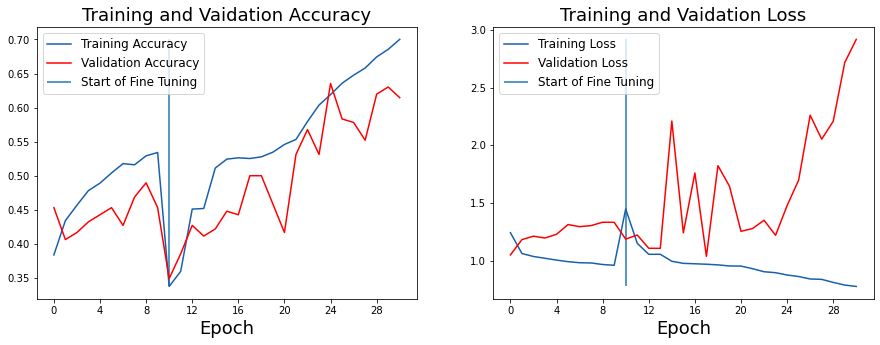

In [49]:
train_acc = history['VGG16'].history['accuracy'].copy()
valid_acc = history['VGG16'].history['val_accuracy'].copy()
train_acc += history['VGG16_fine'].history['accuracy']
valid_acc += history['VGG16_fine'].history['val_accuracy']

train_loss = history['VGG16'].history['loss'].copy()
valid_loss = history['VGG16'].history['val_loss'].copy()
train_loss += history['VGG16_fine'].history['loss']
valid_loss += history['VGG16_fine'].history['val_loss']

accuracy_loss_plotter('VGG16_fine', train_acc, valid_acc, train_loss, valid_loss, initial_epochs)

Confusion matrix, without normalization


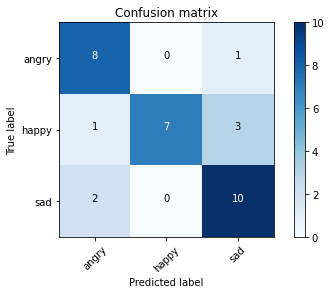

In [50]:
cm = cm_generator(model_vgg16, valid_ds, 1)
plot_cm(cm, label_to_class.keys())

In [51]:
predicted='happy'
wrong_prediction_plotter(model_vgg16, valid_ds, predicted)

Predicted as happy:
No pictures wrongly predicted as happy


Predicted as sad:


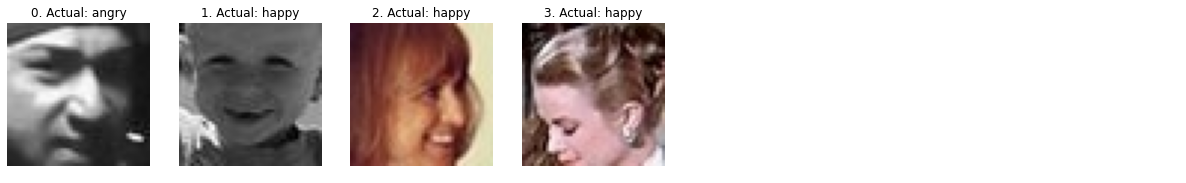

In [52]:
predicted='sad'
wrong_prediction_plotter(model_vgg16, valid_ds, predicted)

Predicted as angry:


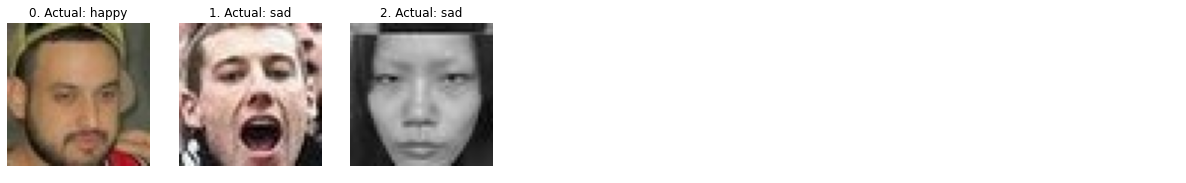

In [53]:
predicted='angry'
wrong_prediction_plotter(model_vgg16, valid_ds, predicted)

**Observations:**
- After retraining, the accuracy of validation set improves from significantly from 48% to 63%. 
- The number of pictures wrongly classified also drops significantly. All happy faces are correctly predicted as happy faces. 
- There are still some pictures wrongly classified as sad and angry. However, these pictures are either quite ambiguous or not showing a clear face (facing sideways). 

### VGGFace

A natural extension of VGG16 is VGGFace. It was constructed with exactly the same layers with VGG16 but was trained on facial images. Therefore, we expect to have a higher accuracy score especially on the baseline training. 

In [206]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /private/var/folders/6j/hw4k0h1n0kj4wl569wh828l40000gn/T/pip-req-build-9a_7yd5i
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /private/var/folders/6j/hw4k0h1n0kj4wl569wh828l40000gn/T/pip-req-build-9a_7yd5i


In [207]:
!pip install keras-applications

#### Baseline Model

In [208]:
# Base model
## Import the Base Model 
from keras_vggface.vggface import VGGFace

## Instantiate the Base Model
base_model_vggface = VGGFace(include_top=False,
                           input_shape=(224, 224, 3),
                           pooling='avg')

## Freeze the base_model
base_model_vggface.trainable = False
## Print model summary
base_model_vggface.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

In [209]:
# Build the model
## Othery layers on top of the Base Model

resizing_layer = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)
dense_layer_1 = tf.keras.layers.Dense(64, kernel_initializer='lecun_normal', name='dense_layer_1', activation='selu')
dropout_layer_1 = tf.keras.layers.AlphaDropout(0.5, name='dropout_layer_1')
dense_layer_2 = tf.keras.layers.Dense(16, kernel_initializer='lecun_normal', name='dense_layer_2', activation='selu')
dropout_layer_2 = tf.keras.layers.AlphaDropout(0.5, name='dropout_layer_2')
if num_of_classes == 2:
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='prediction_layer')
else:
    prediction_layer = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='prediction_layer')

## Define the model flow
inputs = tf.keras.Input(shape=(48, 48, 3), name='input_layer')
x = resizing_layer(inputs)
x = base_model_vggface(x, training=False)
x = dense_layer_1(x)
x = dropout_layer_1(x)
x = dense_layer_2(x)
x = dropout_layer_2(x)
outputs = prediction_layer(x)
model_vggface = tf.keras.Model(inputs, outputs)

model_vggface.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 48, 48, 3)]       0         
_________________________________________________________________
resizing_2 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
vggface_vgg16 (Functional)   (None, 512)               14714688  
_________________________________________________________________
dense_layer_1 (Dense)        (None, 64)                32832     
_________________________________________________________________
dropout_layer_1 (AlphaDropou (None, 64)                0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 16)                1040      
_________________________________________________________________
dropout_layer_2 (AlphaDropou (None, 16)                0  

In [210]:
base_learning_rate = 0.001

if num_of_classes == 2:
    model_vggface.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
else:
    model_vggface.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

initial_epochs = 10
history['VGGFace'] =  model_vggface.fit(train_ds, 
                                  validation_data=valid_ds, 
                                  epochs=initial_epochs, 
                                  verbose=1)

Epoch 1/10
308/308 [==============================] - 753s 2s/step - loss: 1.2396 - accuracy: 0.3987 - val_loss: 0.8854 - val_accuracy: 0.5417
Epoch 2/10
308/308 [==============================] - 981s 3s/step - loss: 0.8491 - accuracy: 0.5986 - val_loss: 0.8366 - val_accuracy: 0.6875
Epoch 3/10
308/308 [==============================] - 642s 2s/step - loss: 0.7719 - accuracy: 0.6577 - val_loss: 0.8063 - val_accuracy: 0.7240
Epoch 4/10
308/308 [==============================] - 675s 2s/step - loss: 0.7297 - accuracy: 0.6745 - val_loss: 0.8617 - val_accuracy: 0.7135
Epoch 5/10
308/308 [==============================] - 527s 2s/step - loss: 0.6842 - accuracy: 0.6993 - val_loss: 0.8781 - val_accuracy: 0.7031
Epoch 6/10
308/308 [==============================] - 428s 1s/step - loss: 0.6735 - accuracy: 0.7121 - val_loss: 0.9781 - val_accuracy: 0.6979
Epoch 7/10
308/308 [==============================] - 432s 1s/step - loss: 0.6593 - accuracy: 0.7190 - val_loss: 0.9047 - val_accuracy: 0.6875

In [211]:
model_vggface.save('./saved_models/model_vggface_baseline.h5')

##### Performance Review

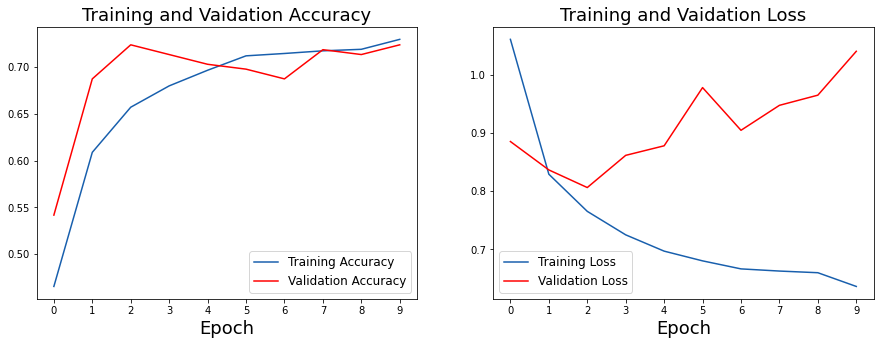

In [212]:
train_acc = history['VGGFace'].history['accuracy']
valid_acc = history['VGGFace'].history['val_accuracy']
train_loss = history['VGGFace'].history['loss']
valid_loss = history['VGGFace'].history['val_loss']

accuracy_loss_plotter('VGGFace', train_acc, valid_acc, train_loss, valid_loss)

Confusion matrix, without normalization


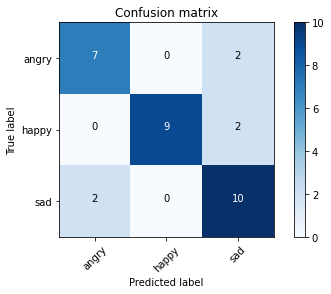

In [213]:
cm = cm_generator(model_vggface, valid_ds, 1)
plot_cm(cm, label_to_class.keys())

In [214]:
predicted='happy'
wrong_prediction_plotter(model_vggface, valid_ds, predicted)

Predicted as happy:
No pictures wrongly predicted as happy


Predicted as sad:


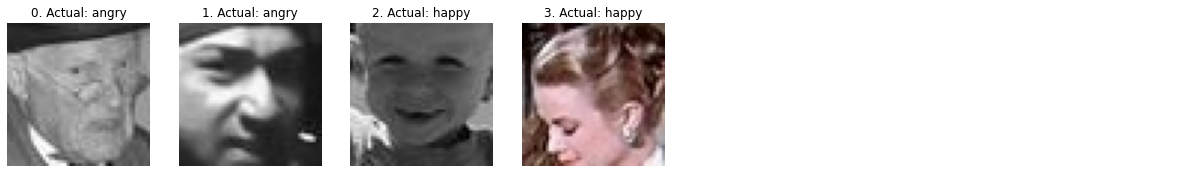

In [215]:
predicted='sad'
wrong_prediction_plotter(model_vggface, valid_ds, predicted)

Predicted as angry:


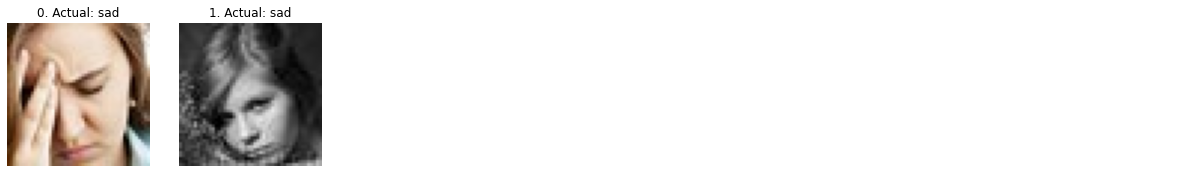

In [216]:
predicted='angry'
wrong_prediction_plotter(model_vggface, valid_ds, predicted)

**Observations:**
- As expected, VGGFace performs very well for this dataset. Not only it manages to increases the validation accuracy to almost 75%, it also manages to do so with very little overfitting as the training and validation accuracy improves in a similar rate. 
- We will subsequently fine tune the model to obtain a higher accuracy level out of the model. 

#### Fine Tuning

Similarly to VGG16 model, we will retrain the VGGFace CNN on the its last block (last 5 layers). 

In [217]:
model_vggface = tf.keras.models.load_model('./saved_models/model_vggface_baseline.h5')

In [218]:
len(base_model_vggface.layers)

20

In [219]:
base_model_vggface.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_vggface.layers[:fine_tune_at]:
    layer.trainable =  False

In [220]:
if num_of_classes == 2:
    model_vggface.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
else:
    model_vggface.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_vggface.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 48, 48, 3)]       0         
_________________________________________________________________
resizing_2 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
vggface_vgg16 (Functional)   (None, 512)               14714688  
_________________________________________________________________
dense_layer_1 (Dense)        (None, 64)                32832     
_________________________________________________________________
dropout_layer_1 (AlphaDropou (None, 64)                0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 16)                1040      
_________________________________________________________________
dropout_layer_2 (AlphaDropou (None, 16)                0  

In [221]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience = 3,
                                        factor = 0.50,
                                        min_lr = 1e-10,
                                        verbose = 1)

es = tf.keras.callbacks.EarlyStopping(verbose=1,
                                        monitor='val_accuracy',
                                        patience=6,
                                        min_delta=0.001,
                                        restore_best_weights=True)

mcp_path = './saved_models/model_vggface.h5'
mcp = tf.keras.callbacks.ModelCheckpoint(mcp_path,
                                         monitor='val_accuracy',
                                         verbose=0,
                                         save_best_only=True,
                                         save_weights_only=False)

history['VGGFace_fine'] = model_vggface.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history['VGGFace'].epoch[-1]+1,
                         validation_data=valid_ds,
                         callbacks=[lrd, es, mcp],
                         verbose=1)

Epoch 11/40
308/308 [==============================] - 444s 1s/step - loss: 0.6315 - accuracy: 0.7317 - val_loss: 0.8967 - val_accuracy: 0.7135
Epoch 12/40
308/308 [==============================] - 469s 2s/step - loss: 0.6187 - accuracy: 0.7426 - val_loss: 1.0994 - val_accuracy: 0.7083
Epoch 13/40
308/308 [==============================] - 457s 1s/step - loss: 0.6157 - accuracy: 0.7449 - val_loss: 1.1573 - val_accuracy: 0.7240
Epoch 14/40
308/308 [==============================] - 429s 1s/step - loss: 0.6246 - accuracy: 0.7320 - val_loss: 1.0363 - val_accuracy: 0.7292
Epoch 15/40
308/308 [==============================] - 431s 1s/step - loss: 0.6085 - accuracy: 0.7368 - val_loss: 0.9765 - val_accuracy: 0.7552
Epoch 16/40
308/308 [==============================] - 422s 1s/step - loss: 0.6165 - accuracy: 0.7397 - val_loss: 1.1081 - val_accuracy: 0.7135
Epoch 17/40
308/308 [==============================] - 422s 1s/step - loss: 0.5969 - accuracy: 0.7486 - val_loss: 1.2313 - val_accuracy:

In [223]:
model_vggface.save('./saved_models/model_vggface_fine.h5')

##### Performance Review

In [199]:
# model_vggface = tf.keras.models.load_model('./saved_models/model_vggface.h5')

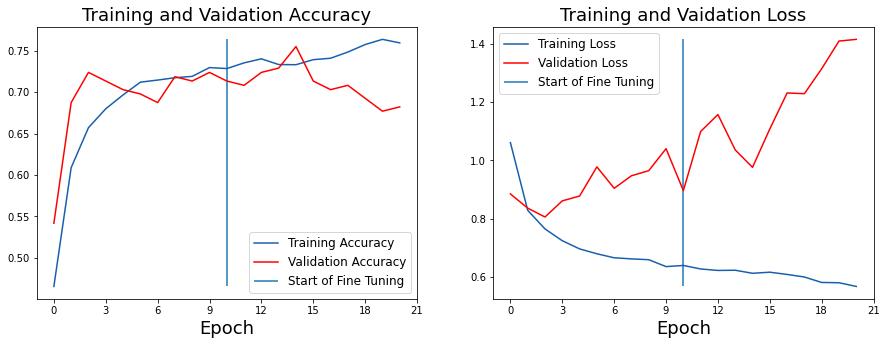

In [230]:
train_acc = history['VGGFace'].history['accuracy'].copy()
valid_acc = history['VGGFace'].history['val_accuracy'].copy()
train_acc += history['VGGFace_fine'].history['accuracy']
valid_acc += history['VGGFace_fine'].history['val_accuracy']

train_loss = history['VGGFace'].history['loss'].copy()
valid_loss = history['VGGFace'].history['val_loss'].copy()
train_loss += history['VGGFace_fine'].history['loss']
valid_loss += history['VGGFace_fine'].history['val_loss']

accuracy_loss_plotter('VGGFace_fine', train_acc, valid_acc, train_loss, valid_loss, initial_epochs)

Confusion matrix, without normalization


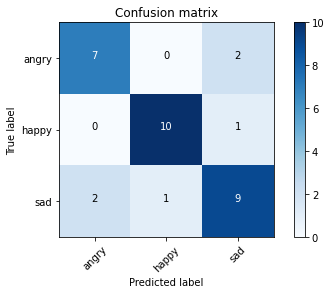

In [225]:
cm = cm_generator(model_vggface, valid_ds, 1)
plot_cm(cm, label_to_class.keys())

Predicted as happy:


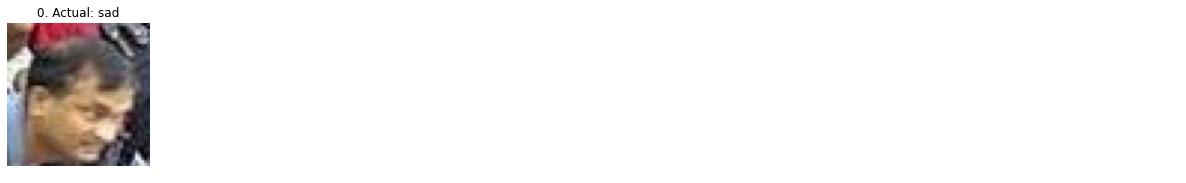

In [226]:
predicted='happy'
wrong_prediction_plotter(model_vggface, valid_ds, predicted)

Predicted as sad:


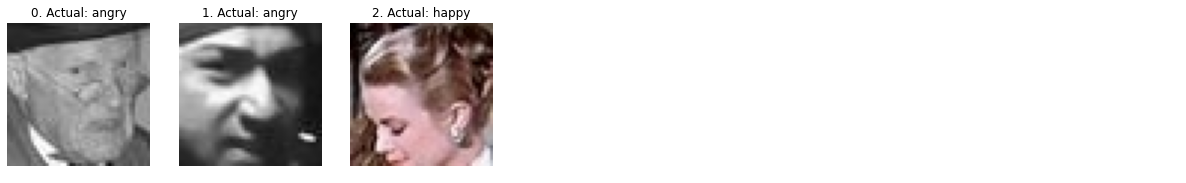

In [227]:
predicted='sad'
wrong_prediction_plotter(model_vggface, valid_ds, predicted)

Predicted as angry:


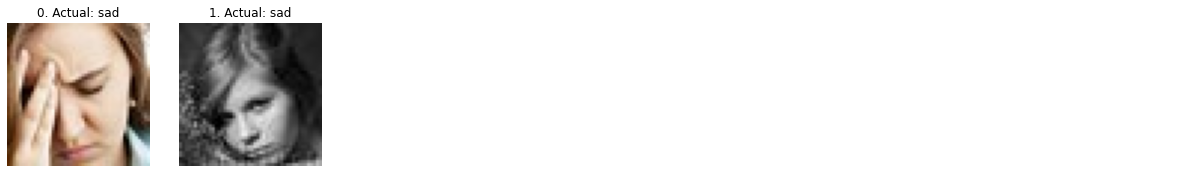

In [228]:
predicted='angry'
wrong_prediction_plotter(model_vggface, valid_ds, predicted)

**Observations:**
- After fine tuning by adjusting retraining last block of the CNN, the accuracy further improves from 72% to 75%. There are only 6 out of 32 pictures from first mini-batch on the validation set that is wrongly classified. Out of which, mostly the picture itself are not very clear on the emotion. 
- Therefore, it seems that VGGFace has performed remarkeably-well even on a dirty dataset.

**Remarks on High Validation Loss**
- Note, however, that similar to the pattern we observe on VGG16 model, the validation set loss increases even when the accuracy still improves. This pattern can and do happen on some occasions and explained well in this [source](https://stats.stackexchange.com/questions/282160/how-is-it-possible-that-validation-loss-is-increasing-while-validation-accuracy). In short, accuracy and loss are intuititively goes the opposite direction. However, they **do not** measure the inverse of a single metric. Instead, loss measures the difference between raw prediction (between 0 and 1 in floating scale) with the actual class while accuracy measures the difference between the final prediction (0 or 1) to the actual class. 
    - Although increase in loss may be a sign of overfitting, however, the model is **still** in the process of learning useful signal for other images. Therefore, without going to the rabbit hole to find the best combination loss and accuracy, we will use the model with the highest validation accuracy without considering the validation loss. 

### ResNet50

Another popular pretrained model for facial recognition is Residual Network (ResNet) ([source](https://www.sciencedirect.com/science/article/abs/pii/S0925231220308572)). Before introduction of ResNet, CNN layers tend to be shorter due to the problem with vanishing gradient problem for deeper network. To overcome this, ResNet allows a shortcut for information to 'jump' layer, therefore, retaining the information and allowing for a deeper network ([source](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)). 

For this example, we will use ResNet50 with the total CNN depth of 50 layers. 

#### Baseline Model

In [261]:
# Base model
## Import the Base Model 
# import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

## Instantiate the Base Model based on RESNET50 architecture; default weights from'imagenet'
base_model_resnet50 = ResNet50(include_top=False,
                      input_shape=(48, 48, 3),
                      pooling='avg')

## Freeze the base_model
base_model_resnet50.trainable = False
## Print model summary
base_model_resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_22[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [262]:
# Build the model
## Othery layers on top of the Base Model

dense_layer_1 = tf.keras.layers.Dense(512, kernel_initializer='lecun_normal', name='dense_layer_1', activation='selu')
dropout_layer_1 = tf.keras.layers.AlphaDropout(0.5, name='dropout_layer_1')
dense_layer_2 = tf.keras.layers.Dense(32, kernel_initializer='lecun_normal', name='dense_layer_2', activation='selu')
dropout_layer_2 = tf.keras.layers.AlphaDropout(0.5, name='dropout_layer_2')

if num_of_classes == 2:
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='prediction_layer')
else:
    prediction_layer = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='prediction_layer')

## Define the model flow
inputs = tf.keras.Input(shape=(48, 48, 3), name='input_layer')
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model_resnet50(x, training=False)
x = dense_layer_1(x)
x = dropout_layer_1(x)
x = dense_layer_2(x)
x = dropout_layer_2(x)
outputs = prediction_layer(x)
model_resnet50 = tf.keras.Model(inputs, outputs)

model_resnet50.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_9 ( (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_9 (TFOpLambda (None, 48, 48, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_layer_1 (Dense)        (None, 512)               1049088   
_________________________________________________________________
dropout_layer_1 (AlphaDropou (None, 512)               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 32)                164

In [263]:
base_learning_rate = 0.001

if num_of_classes == 2:
    model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
else:
    model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

initial_epochs = 10
history['ResNet50'] =  model_resnet50.fit(train_ds, 
                                  validation_data=valid_ds, 
                                  epochs=initial_epochs, 
                                  verbose=1)

Epoch 1/10
308/308 [==============================] - 47s 149ms/step - loss: 1.1293 - accuracy: 0.4201 - val_loss: 1.2194 - val_accuracy: 0.4479
Epoch 2/10
308/308 [==============================] - 45s 145ms/step - loss: 1.0144 - accuracy: 0.4960 - val_loss: 1.6590 - val_accuracy: 0.4740
Epoch 3/10
308/308 [==============================] - 44s 144ms/step - loss: 0.9702 - accuracy: 0.5133 - val_loss: 1.6100 - val_accuracy: 0.4635
Epoch 4/10
308/308 [==============================] - 44s 144ms/step - loss: 0.9370 - accuracy: 0.5459 - val_loss: 1.7826 - val_accuracy: 0.5000
Epoch 5/10
308/308 [==============================] - 44s 144ms/step - loss: 0.9045 - accuracy: 0.5629 - val_loss: 1.6879 - val_accuracy: 0.4844
Epoch 6/10
308/308 [==============================] - 45s 146ms/step - loss: 0.8693 - accuracy: 0.5788 - val_loss: 1.8521 - val_accuracy: 0.4427
Epoch 7/10
308/308 [==============================] - 45s 145ms/step - loss: 0.8230 - accuracy: 0.5986 - val_loss: 2.1793 - val_ac

##### Performance Review

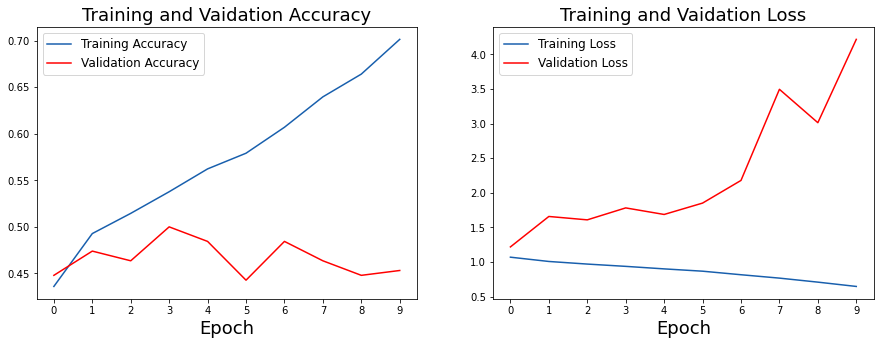

In [264]:
train_acc = history['ResNet50'].history['accuracy']
valid_acc = history['ResNet50'].history['val_accuracy']
train_loss = history['ResNet50'].history['loss']
valid_loss = history['ResNet50'].history['val_loss']

accuracy_loss_plotter('ResNet50', train_acc, valid_acc, train_loss, valid_loss)

Confusion matrix, without normalization


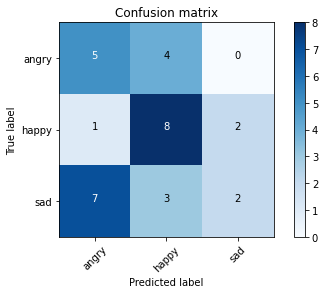

In [265]:
cm = cm_generator(model_resnet50, valid_ds, 1)
plot_cm(cm, label_to_class.keys())

Predicted as happy:


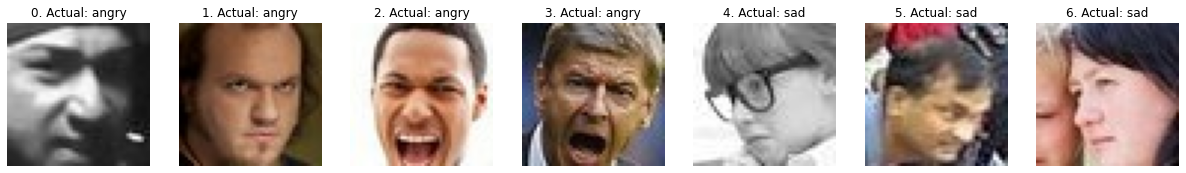

In [266]:
predicted='happy'
wrong_prediction_plotter(model_resnet50, valid_ds, predicted)

Predicted as sad:


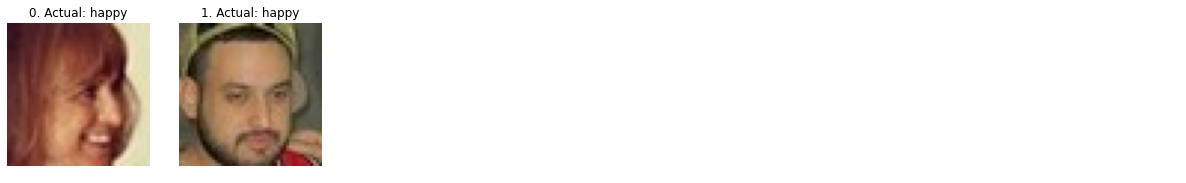

In [267]:
predicted='sad'
wrong_prediction_plotter(model_resnet50, valid_ds, predicted)

Predicted as angry:


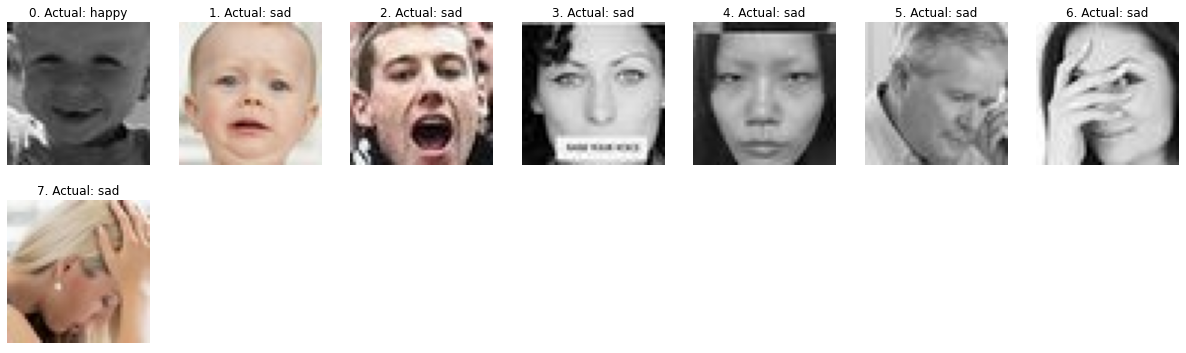

In [268]:
predicted='angry'
wrong_prediction_plotter(model_resnet50, valid_ds, predicted)

**Observations:**
- From the validation accuracy and loss graph, we can see that there is a tendency of overfitting. I increased the Dropout from 0.1 all the way to 0.6 to regularize the model. It improves the model but not with significant margin. Let's perform further fine tuning to see if we can tweak the model better. 

#### Fine Tuning

In [269]:
len(base_model_resnet50.layers)

176

In [270]:
base_model_resnet50.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 165

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_resnet50.layers[:fine_tune_at]:
    layer.trainable =  False

In [271]:
if num_of_classes == 2:
    model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
else:
    model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_resnet50.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_9 ( (None, 48, 48, 3)         0         
_________________________________________________________________
tf.nn.bias_add_9 (TFOpLambda (None, 48, 48, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_layer_1 (Dense)        (None, 512)               1049088   
_________________________________________________________________
dropout_layer_1 (AlphaDropou (None, 512)               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 32)                164

In [272]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience = 3,
                                        factor = 0.50,
                                        min_lr = 1e-10,
                                        verbose = 1)

es = tf.keras.callbacks.EarlyStopping(verbose=1,
                                        monitor='val_accuracy',
                                        patience=6,
                                        min_delta=0.001,
                                        restore_best_weights=True)

mcp_path = './saved_models/model_resnet50.h5'
mcp = tf.keras.callbacks.ModelCheckpoint(mcp_path,
                                         monitor='val_accuracy',
                                         verbose=0,
                                         save_best_only=True,
                                         save_weights_only=False)

history['ResNet50_fine'] = model_resnet50.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history['ResNet50'].epoch[-1]+1,
                         validation_data=valid_ds,
                         callbacks=[lrd, es, mcp],
                         verbose=1)

Epoch 11/40
308/308 [==============================] - 52s 163ms/step - loss: 0.8605 - accuracy: 0.6267 - val_loss: 4.5721 - val_accuracy: 0.4531
Epoch 12/40
308/308 [==============================] - 49s 160ms/step - loss: 0.6443 - accuracy: 0.7145 - val_loss: 3.1420 - val_accuracy: 0.4583
Epoch 13/40
308/308 [==============================] - 49s 160ms/step - loss: 0.5398 - accuracy: 0.7665 - val_loss: 5.3501 - val_accuracy: 0.4323
Epoch 14/40
308/308 [==============================] - 49s 160ms/step - loss: 0.4731 - accuracy: 0.8025 - val_loss: 11.0514 - val_accuracy: 0.4531
Epoch 15/40
308/308 [==============================] - 49s 160ms/step - loss: 0.3912 - accuracy: 0.8545 - val_loss: 16.4897 - val_accuracy: 0.4635
Epoch 16/40
308/308 [==============================] - 49s 159ms/step - loss: 0.3270 - accuracy: 0.8808 - val_loss: 11.8308 - val_accuracy: 0.4167
Epoch 17/40
308/308 [==============================] - 49s 160ms/step - loss: 0.2415 - accuracy: 0.9191 - val_loss: 10.10

In [274]:
model_resnet50.save('./saved_models/model_resnet50.h5')

##### Performance Review

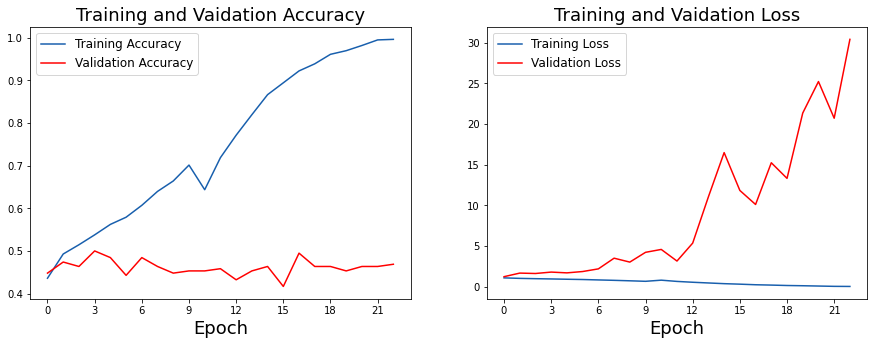

In [275]:
train_acc = history['ResNet50'].history['accuracy'].copy()
valid_acc = history['ResNet50'].history['val_accuracy'].copy()
train_acc += history['ResNet50_fine'].history['accuracy']
valid_acc += history['ResNet50_fine'].history['val_accuracy']

train_loss = history['ResNet50'].history['loss'].copy()
valid_loss = history['ResNet50'].history['val_loss'].copy()
train_loss += history['ResNet50_fine'].history['loss']
valid_loss += history['ResNet50_fine'].history['val_loss']

accuracy_loss_plotter('ResNet50_fine', train_acc, valid_acc, train_loss, valid_loss)

Confusion matrix, without normalization


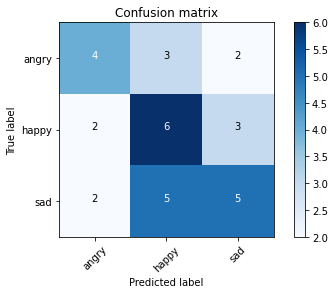

In [276]:
cm = cm_generator(model_resnet50, valid_ds, 1)
plot_cm(cm, label_to_class.keys())

Predicted as happy:


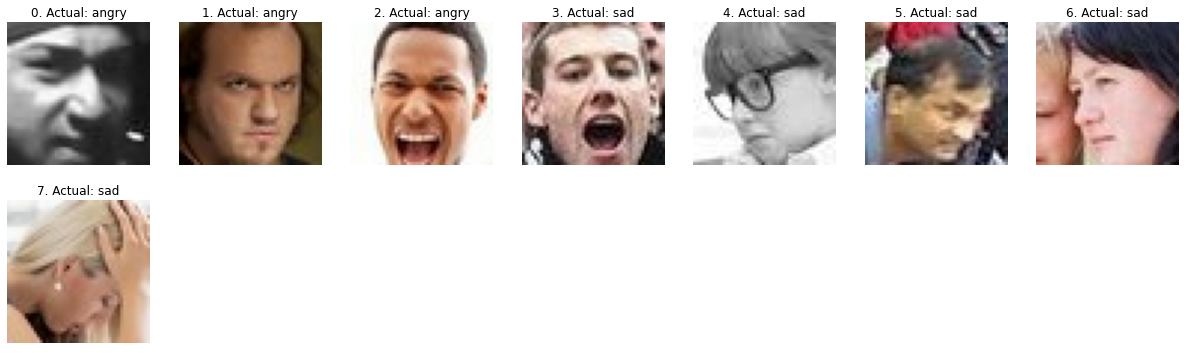

In [277]:
predicted='happy'
wrong_prediction_plotter(model_resnet50, valid_ds, predicted)

Predicted as sad:


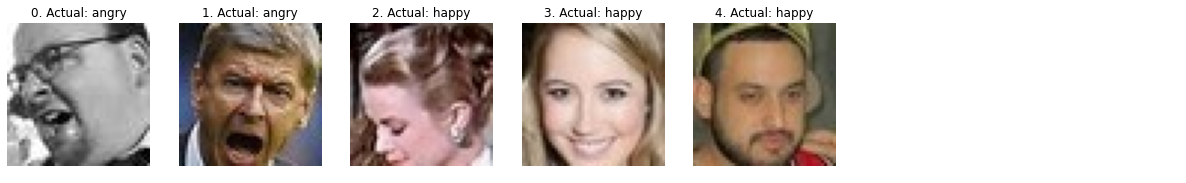

In [278]:
predicted='sad'
wrong_prediction_plotter(model_resnet50, valid_ds, predicted)

Predicted as angry:


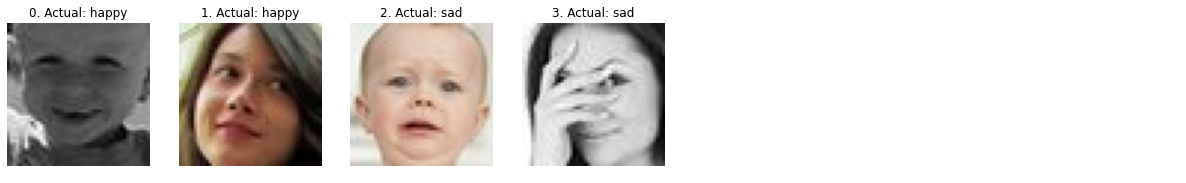

In [279]:
predicted='angry'
wrong_prediction_plotter(model_resnet50, valid_ds, predicted)

**Observations:**
- Even after fine tuning, ResNet50 does not perform as well as VGG16 or VGGFace. This may indicate two things: 1. not all complex model are performing better than the simpler ones, 2. we may need to further tune and train ResNet50 to suit for this purpose better. 
- I personally believe with more time, ResNet50 is able to be tuned to perform at least as well as VGGFace.

## Custom Model

### Custom Model 1

In [301]:
model_custom_1 = tf.keras.Sequential()

model_custom_1.add(tf.keras.Input(shape=(48, 48, 3), name='input_layer'))

# Convolution layer block 1
model_custom_1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, name='conv_layer_1a'))
model_custom_1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, name='conv_layer_1b'))
model_custom_1.add(tf.keras.layers.Activation('relu'))
model_custom_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_1'))

# Convolution layer block 2
model_custom_1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, name='conv_layer_2a'))
model_custom_1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, name='conv_layer_2b'))
model_custom_1.add(tf.keras.layers.Activation('relu'))
model_custom_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_2'))

# Convolution layer block 3
model_custom_1.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, name='conv_layer_3a'))
model_custom_1.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, name='conv_layer_3b'))
model_custom_1.add(tf.keras.layers.Activation('relu'))
model_custom_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_3'))

model_custom_1.add(tf.keras.layers.GlobalAveragePooling2D())

# Fully Connected Network 1
model_custom_1.add(tf.keras.layers.Dropout(0.25))
model_custom_1.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Fully Connected Network 2
model_custom_1.add(tf.keras.layers.Dropout(0.25))
model_custom_1.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Prediction Layer
model_custom_1.add(tf.keras.layers.Dropout(0.25))
if num_of_classes == 2:
    model_custom_1.add(tf.keras.layers.Dense(
      units=1,
      activation='sigmoid',
  ))
else:
    model_custom_1.add(tf.keras.layers.Dense(
      units=num_of_classes,
      activation='softmax',
  ))

model_custom_1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer_1a (Conv2D)       (None, 46, 46, 64)        1792      
_________________________________________________________________
conv_layer_1b (Conv2D)       (None, 44, 44, 64)        36928     
_________________________________________________________________
activation_9 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
pool_layer_1 (MaxPooling2D)  (None, 22, 22, 64)        0         
_________________________________________________________________
conv_layer_2a (Conv2D)       (None, 20, 20, 128)       73856     
_________________________________________________________________
conv_layer_2b (Conv2D)       (None, 18, 18, 128)       147584    
_________________________________________________________________
activation_10 (Activation)   (None, 18, 18, 128)     

In [302]:
base_learning_rate = 0.001
if num_of_classes == 2:
    model_custom_1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])
else:
    model_custom_1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [303]:
epochs_no = 30

lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience = 3,
                                        factor = 0.50,
                                        min_lr = 1e-10,
                                        verbose = 1)

es = tf.keras.callbacks.EarlyStopping(verbose=1,
                                        monitor='val_accuracy',
                                        patience=6,
                                        min_delta=0.001)

mcp_path = './saved_models/model_custom_1.h5'
mcp = tf.keras.callbacks.ModelCheckpoint(mcp_path,
                                         monitor='val_accuracy',
                                         verbose=0,
                                         save_best_only=True,
                                         save_weights_only=False)

history['Custom_1'] = model_custom_1.fit(train_ds,
                         epochs=epochs_no,
                         validation_data=valid_ds,
                         callbacks=[lrd, es, mcp],
                         verbose=1)

Epoch 1/30
308/308 [==============================] - 27s 87ms/step - loss: 90918835.8701 - accuracy: 0.3248 - val_loss: 1.0985 - val_accuracy: 0.3490
Epoch 2/30
308/308 [==============================] - 26s 83ms/step - loss: 27969704598.8045 - accuracy: 0.3203 - val_loss: 1.0982 - val_accuracy: 0.3490
Epoch 3/30
308/308 [==============================] - 26s 85ms/step - loss: 47165309775.9802 - accuracy: 0.3351 - val_loss: 1.0979 - val_accuracy: 0.3490
Epoch 4/30
308/308 [==============================] - 26s 85ms/step - loss: 2538296817.5143 - accuracy: 0.3218 - val_loss: 1.0978 - val_accuracy: 0.3490

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
308/308 [==============================] - 29s 93ms/step - loss: 37271242533.4380 - accuracy: 0.3354 - val_loss: 1.0979 - val_accuracy: 0.3490
Epoch 6/30
308/308 [==============================] - 29s 93ms/step - loss: 1.0986 - accuracy: 0.3310 - val_loss: 1.0979 - val_accuracy: 0.3490
Epoch 7/3

In [304]:
tf.keras.models.save_model(model_custom_1, filepath='./saved_models/model_custom_1_last.h5')

#### Performance

In [305]:
model_custom_1 = tf.keras.models.load_model('./saved_models/model_custom_1.h5')

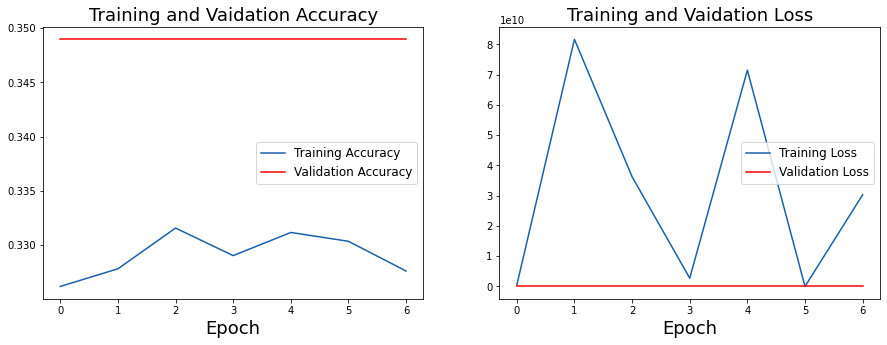

In [306]:
train_acc = history['Custom_1'].history['accuracy']
valid_acc = history['Custom_1'].history['val_accuracy']
train_loss = history['Custom_1'].history['loss']
valid_loss = history['Custom_1'].history['val_loss']

accuracy_loss_plotter('Custom_1', train_acc, valid_acc, train_loss, valid_loss)

Confusion matrix, without normalization


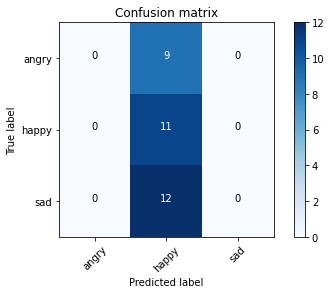

In [307]:
cm = cm_generator(model_custom_1, valid_ds, 1)
plot_cm(cm, label_to_class.keys())

Predicted as happy:


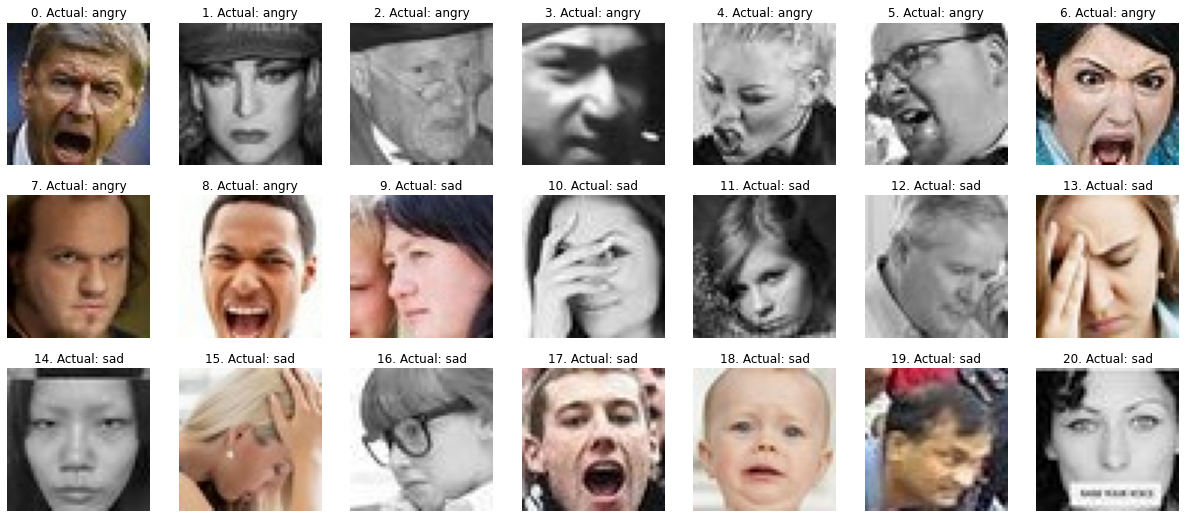

In [308]:
predicted='happy'
wrong_prediction_plotter(model_custom_1, valid_ds, predicted)

In [309]:
predicted='sad'
wrong_prediction_plotter(model_custom_1, valid_ds, predicted)

Predicted as sad:
No pictures wrongly predicted as sad


In [310]:
predicted='angry'
wrong_prediction_plotter(model_custom_1, valid_ds, predicted)

Predicted as angry:
No pictures wrongly predicted as angry


**Observations:**
- The first model we built performs poorly on our dataset as it is unable to capture the facial feature and fit even on the training dataset. Closer observation on the training loss reveals that the model may suffer the problem of having exploding gradient on its layer ([source](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/)). 
- One way to mitigate exploding gradient problem on smaller CNN network is by introducing batch normalization to ensure no one input that saturate the output ([source](https://www.quora.com/How-does-Batch-Normalization-battle-the-fact-that-gradients-might-explode-when-training-a-Neural-Network)). In the next model, we will introduce batch normalization to observe if it helps. 

### Custom Model 2

As mentioned earlier, custom model 2 will retain most of the features that custom model 1 has with the addition of batch normalization right before activation layer on each convolution block. Number of filters on each convolution layers and units on densely connected layers are to be kept the same. 

In [291]:
model_custom_2 = tf.keras.Sequential()

model_custom_2.add(tf.keras.Input(shape=(48, 48, 3), name='input_layer'))

# Convolution layer block 1
model_custom_2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, name='conv_layer_1a'))
model_custom_2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, name='conv_layer_1b'))
model_custom_2.add(tf.keras.layers.BatchNormalization())
model_custom_2.add(tf.keras.layers.Activation('relu'))
model_custom_2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_1'))

# Convolution layer block 2
model_custom_2.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, name='conv_layer_2a'))
model_custom_2.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, name='conv_layer_2b'))
model_custom_2.add(tf.keras.layers.BatchNormalization())
model_custom_2.add(tf.keras.layers.Activation('relu'))
model_custom_2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_2'))

# Convolution layer block 3
model_custom_2.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, name='conv_layer_3a'))
model_custom_2.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, name='conv_layer_3b'))
model_custom_2.add(tf.keras.layers.BatchNormalization())
model_custom_2.add(tf.keras.layers.Activation('relu'))
model_custom_2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_3'))
model_custom_2.add(tf.keras.layers.GlobalAveragePooling2D())

# Fully Connected Network 1
model_custom_2.add(tf.keras.layers.Dropout(0.25))
model_custom_2.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Fully Connected Network 2
model_custom_2.add(tf.keras.layers.Dropout(0.25))
model_custom_2.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Prediction Layer 
model_custom_2.add(tf.keras.layers.Dropout(0.25))
if num_of_classes == 2:
    model_custom_2.add(tf.keras.layers.Dense(
      units=1,
      activation='sigmoid',
  ))
else:
    model_custom_2.add(tf.keras.layers.Dense(
      units=num_of_classes,
      activation='softmax',
  ))

model_custom_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer_1a (Conv2D)       (None, 46, 46, 64)        1792      
_________________________________________________________________
conv_layer_1b (Conv2D)       (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
pool_layer_1 (MaxPooling2D)  (None, 22, 22, 64)        0         
_________________________________________________________________
conv_layer_2a (Conv2D)       (None, 20, 20, 128)       73856     
_________________________________________________________________
conv_layer_2b (Conv2D)       (None, 18, 18, 128)     

In [292]:
base_learning_rate = 0.001
if num_of_classes == 2:
    model_custom_2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])
else:
    model_custom_2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [293]:
epochs_no = 30

lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience = 3,
                                        factor = 0.50,
                                        min_lr = 1e-10,
                                        verbose = 1)

es = tf.keras.callbacks.EarlyStopping(verbose=3,
                                        monitor='val_accuracy',
                                        patience=6,
                                        min_delta=0.001)

mcp_path = './saved_models/model_custom_2.h5'
mcp = tf.keras.callbacks.ModelCheckpoint(mcp_path,
                                         monitor='val_accuracy',
                                         verbose=0,
                                         save_best_only=True,
                                         save_weights_only=False)

history['Custom_2'] = model_custom_2.fit(train_ds,
                         epochs=epochs_no,
                         validation_data=valid_ds,
                         callbacks=[lrd, es, mcp],
                         verbose=1)

Epoch 1/30
308/308 [==============================] - 25s 80ms/step - loss: 1.1953 - accuracy: 0.3945 - val_loss: 1.1098 - val_accuracy: 0.4062
Epoch 2/30
308/308 [==============================] - 24s 78ms/step - loss: 1.0845 - accuracy: 0.4101 - val_loss: 1.0664 - val_accuracy: 0.4062
Epoch 3/30
308/308 [==============================] - 24s 79ms/step - loss: 1.0209 - accuracy: 0.4796 - val_loss: 1.0670 - val_accuracy: 0.4531
Epoch 4/30
308/308 [==============================] - 24s 80ms/step - loss: 0.9469 - accuracy: 0.5441 - val_loss: 1.1353 - val_accuracy: 0.4896
Epoch 5/30
308/308 [==============================] - 25s 80ms/step - loss: 0.8688 - accuracy: 0.5903 - val_loss: 1.0380 - val_accuracy: 0.4948
Epoch 6/30
308/308 [==============================] - 24s 79ms/step - loss: 0.8118 - accuracy: 0.6358 - val_loss: 0.9252 - val_accuracy: 0.5469
Epoch 7/30
308/308 [==============================] - 25s 81ms/step - loss: 0.7714 - accuracy: 0.6615 - val_loss: 0.9061 - val_accuracy:

In [294]:
tf.keras.models.save_model(model_custom_2, filepath='./saved_models/model_custom_2_last.h5')

#### Performance

In [295]:
model_custom_2 = tf.keras.models.load_model('./saved_models/model_custom_2.h5')

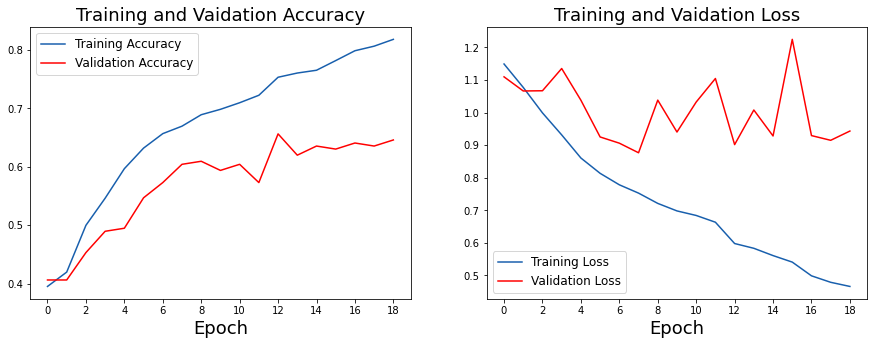

In [296]:
train_acc = history['Custom_2'].history['accuracy']
valid_acc = history['Custom_2'].history['val_accuracy']
train_loss = history['Custom_2'].history['loss']
valid_loss = history['Custom_2'].history['val_loss']

accuracy_loss_plotter('Custom_2', train_acc, valid_acc, train_loss, valid_loss)

Confusion matrix, without normalization


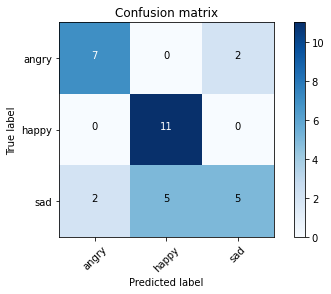

In [297]:
cm = cm_generator(model_custom_2, valid_ds, 1)
plot_cm(cm, label_to_class.keys())

Predicted as happy:


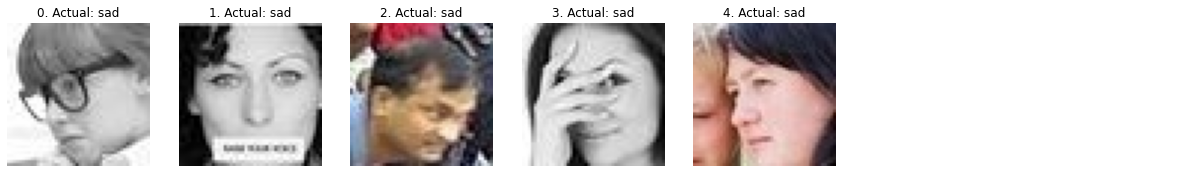

In [298]:
predicted='happy'
wrong_prediction_plotter(model_custom_2, valid_ds, predicted)

Predicted as sad:


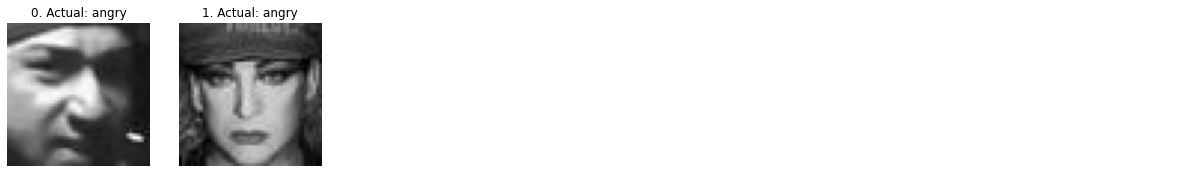

In [299]:
predicted='sad'
wrong_prediction_plotter(model_custom_2, valid_ds, predicted)

Predicted as angry:


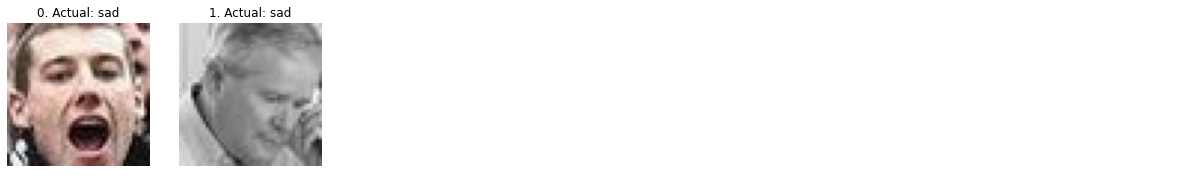

In [300]:
predicted='angry'
wrong_prediction_plotter(model_custom_2, valid_ds, predicted)

**Observations:**
- The model has improved significantly by adding layer of batch normalization on every convolution blocks. This shows that batch normalization successfully mitigates the exploding gradient problem that custom model 1 suffers earlier. 
- The custom model 2 manages to achieve 65% accuracy on the validation dataset. Not bad at all for simple model trained within 19 epochs! 
- Furthermore, we will attempt to further improve the model performance by tuning its hyperparameter. 

### Keras Tuner

Our custom model was initially generated mostly based on intuition, i.e. three blocks of convolutions with increasing filter size followed by three fully connected layers with decreasing units size. In this chapter, we will perform adjustment to this setup based on keras tuner tuning module. The three main parameters to be tuned are:
- Number of filters on convolution blocks
- Number of units for each dense layer
- Value of dropout for each dense layer

We will employ Random Search to reduce the computational time required to find the best set of values. Furthermore, we will split the search into three stages for the three sets of parameters. This approach may not provide the best possible set of values, but it will reduce the number of permutation to be check significantly. 

In [311]:
from kerastuner.tuners import RandomSearch

#### Convolution Filter Tuning

To perform the tuning on convolution layers, we will still employ general pattern that we go for a higher number of filters at each convolution block.

In [314]:
# Find the best number of filters for each convolution
def generate_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(48, 48, 3), name='input_layer'))
    
    model.add(keras.layers.Conv2D(filters=hp.Choice(f"conv_layer_1a_filters", [32, 64]), kernel_size=3))
    model.add(keras.layers.Conv2D(filters=hp.Choice(f"conv_layer_1b_filters", [32, 64]), kernel_size=3)) 
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_1'))
              
    model.add(keras.layers.Conv2D(filters=hp.Choice(f"conv_layer_2a", [128, 256]), kernel_size=3))
    model.add(keras.layers.Conv2D(filters=hp.Choice(f"conv_layer_2b", [128, 256]), kernel_size=3)) 
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_2'))
              
    model.add(keras.layers.Conv2D(filters=hp.Choice(f"conv_layer_3a", [256, 512]), kernel_size=3))
    model.add(keras.layers.Conv2D(filters=hp.Choice(f"conv_layer_3b", [256, 512]), kernel_size=3)) 
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_3'))
              
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))

    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(units=32, activation='relu'))

    model.add(tf.keras.layers.Dropout(0.25))
    if num_of_classes == 2:
        model.add(tf.keras.layers.Dense(
          units=1,
          activation='sigmoid',
      ))
    else:
        model.add(tf.keras.layers.Dense(
          units=num_of_classes,
          activation='softmax',
      ))

    base_learning_rate = 0.001
    if num_of_classes == 2:
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        
    return model

In [315]:
tuner = RandomSearch(
    generate_model,
    objective='val_accuracy',
    max_trials=32,
    directory='./saved_models/keras_tuner_base'
)

tuner.search(train_ds,
             validation_data=valid_ds,
             epochs=10,
             batch_size=32)

Trial 32 Complete [00h 03m 42s]
val_accuracy: 0.6354166865348816

Best val_accuracy So Far: 0.6510416865348816
Total elapsed time: 04h 50m 53s
INFO:tensorflow:Oracle triggered exit


In [320]:
tuner.results_summary()[0:3]

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_layer_1a_filters: 64
conv_layer_1b_filters: 32
conv_layer_2a: 256
conv_layer_2b: 128
conv_layer_3a: 512
conv_layer_3b: 512
Score: 0.6510416865348816
Trial summary
Hyperparameters:
conv_layer_1a_filters: 64
conv_layer_1b_filters: 32
conv_layer_2a: 128
conv_layer_2b: 128
conv_layer_3a: 256
conv_layer_3b: 512
Score: 0.6458333134651184
Trial summary
Hyperparameters:
conv_layer_1a_filters: 64
conv_layer_1b_filters: 64
conv_layer_2a: 128
conv_layer_2b: 128
conv_layer_3a: 256
conv_layer_3b: 256
Score: 0.640625
Trial summary
Hyperparameters:
conv_layer_1a_filters: 32
conv_layer_1b_filters: 64
conv_layer_2a: 128
conv_layer_2b: 128
conv_layer_3a: 256
conv_layer_3b: 256
Score: 0.6354166865348816
Trial summary
Hyperparameters:
conv_layer_1a_filters: 32
conv_layer_1b_filters: 64
conv_layer_2a: 128
conv_layer_2b: 128
conv_layer_3a: 512
conv_layer_3b

In [321]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 44, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 44, 44, 32)        0         
_________________________________________________________________
pool_layer_1 (MaxPooling2D)  (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 256)       73984     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       2

**Observations:**
- The best permutation: 
    - conv_layer_1a: 64
    - conv_layer_1b: 32 
    - conv_layer_2a: 256 
    - conv_layer_2b: 128 
    - conv_layer_3a: 512 
    - conv_layer_3b: 512
- As opposed to our initial believe, the most ideal set of convolution filters are not necessarily has an increaing number of filters per each convolution block. We will use this set of combination for the next tuning step to find the best dense network unit. 

#### Dense Network Tuning

In [334]:
# Find the best number of filters for each convolution
def generate_model_dense(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(48, 48, 3), name='input_layer'))
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, name='conv_layer_1a'))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, name='conv_layer_1b'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_1'))

    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, name='conv_layer_2a'))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, name='conv_layer_2b'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_2'))

    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, name='conv_layer_3a'))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, name='conv_layer_3b'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_3'))
              
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(units=hp.Choice(f"dense_layer_1", [128, 256]), activation='relu'))

    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(units=hp.Choice(f"dense_layer_2", [32, 64]), activation='relu'))

    model.add(tf.keras.layers.Dropout(0.25))
    if num_of_classes == 2:
        model.add(tf.keras.layers.Dense(
          units=1,
          activation='sigmoid',
      ))
    else:
        model.add(tf.keras.layers.Dense(
          units=num_of_classes,
          activation='softmax',
      ))

    base_learning_rate = 0.001
    if num_of_classes == 2:
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        
    return model

In [335]:
tuner_dense = RandomSearch(
    generate_model_dense,
    objective='val_accuracy',
    max_trials=32,
    directory='./saved_models/keras_tuner_dense'
)

tuner_dense.search(train_ds,
             validation_data=valid_ds,
             epochs=10,
             batch_size=32)

Trial 4 Complete [00h 05m 34s]
val_accuracy: 0.6145833134651184

Best val_accuracy So Far: 0.6145833134651184
Total elapsed time: 00h 35m 20s
INFO:tensorflow:Oracle triggered exit


In [339]:
tuner_dense.results_summary()

Results summary
Results in ./keras_tuner_dense/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dense_layer_1: 256
dense_layer_2: 64
Score: 0.6145833134651184
Trial summary
Hyperparameters:
dense_layer_1: 128
dense_layer_2: 64
Score: 0.6145833134651184
Trial summary
Hyperparameters:
dense_layer_1: 128
dense_layer_2: 32
Score: 0.59375
Trial summary
Hyperparameters:
dense_layer_1: 256
dense_layer_2: 32
Score: 0.546875


In [337]:
best_model_dense = tuner_dense.get_best_models()[0]
best_model_dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer_1a (Conv2D)       (None, 46, 46, 64)        1792      
_________________________________________________________________
conv_layer_1b (Conv2D)       (None, 44, 44, 32)        18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 44, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 44, 44, 32)        0         
_________________________________________________________________
pool_layer_1 (MaxPooling2D)  (None, 22, 22, 32)        0         
_________________________________________________________________
conv_layer_2a (Conv2D)       (None, 20, 20, 256)       73984     
_________________________________________________________________
conv_layer_2b (Conv2D)       (None, 18, 18, 128)       2

**Observations:**
- The number of dense nodes which results in the highest accuracy score is:
    - dense_layer_1: 256
    - dense_layer_2: 64
- We will further perform check on the most optimal dropout value, fixing convolution filters and number of dense nodes as found above. 

#### Dropout Value Tuning

In [340]:
# Find the best number of filters for each convolution
def generate_model_dropout(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(48, 48, 3), name='input_layer'))
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, name='conv_layer_1a'))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, name='conv_layer_1b'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_1'))

    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, name='conv_layer_2a'))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, name='conv_layer_2b'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_2'))

    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, name='conv_layer_3a'))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, name='conv_layer_3b'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_3'))
              
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(tf.keras.layers.Dropout(hp.Choice(f"dropout_1", [0.1, 0.25, 0.5])))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))

    model.add(tf.keras.layers.Dropout(hp.Choice(f"dropout_2", [0.1, 0.25, 0.5])))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))

    model.add(tf.keras.layers.Dropout(hp.Choice(f"dropout_3", [0.1, 0.25, 0.5])))
    if num_of_classes == 2:
        model.add(tf.keras.layers.Dense(
          units=1,
          activation='sigmoid',
      ))
    else:
        model.add(tf.keras.layers.Dense(
          units=num_of_classes,
          activation='softmax',
      ))

    base_learning_rate = 0.001
    if num_of_classes == 2:
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        
    return model

In [341]:
tuner_final = RandomSearch(
    generate_model_dropout,
    objective='val_accuracy',
    max_trials=32,
    directory='./saved_models/keras_tuner_final/oracle.json'
)

tuner_final.search(train_ds,
             validation_data=valid_ds,
             epochs=10,
             batch_size=32)

Trial 21 Complete [00h 05m 24s]
val_accuracy: 0.5364583134651184

Best val_accuracy So Far: 0.6614583134651184
Total elapsed time: 05h 18m 56s
INFO:tensorflow:Oracle triggered exit


In [343]:
tuner_final.results_summary()

Results summary
Results in ./keras_tuner_final/oracle.json/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_1: 0.1
dropout_2: 0.1
dropout_3: 0.25
Score: 0.6614583134651184
Trial summary
Hyperparameters:
dropout_1: 0.1
dropout_2: 0.25
dropout_3: 0.25
Score: 0.640625
Trial summary
Hyperparameters:
dropout_1: 0.5
dropout_2: 0.25
dropout_3: 0.1
Score: 0.625
Trial summary
Hyperparameters:
dropout_1: 0.1
dropout_2: 0.1
dropout_3: 0.5
Score: 0.6197916865348816
Trial summary
Hyperparameters:
dropout_1: 0.5
dropout_2: 0.1
dropout_3: 0.25
Score: 0.6197916865348816
Trial summary
Hyperparameters:
dropout_1: 0.25
dropout_2: 0.25
dropout_3: 0.25
Score: 0.6197916865348816
Trial summary
Hyperparameters:
dropout_1: 0.25
dropout_2: 0.1
dropout_3: 0.25
Score: 0.609375
Trial summary
Hyperparameters:
dropout_1: 0.1
dropout_2: 0.25
dropout_3: 0.1
Score: 0.5989583134651184
Trial summary
Hyperparameters:
dropout_1: 0.5
dropout_2: 0.

In [342]:
best_model_final = tuner_final.get_best_models()[0]
best_model_final.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer_1a (Conv2D)       (None, 46, 46, 64)        1792      
_________________________________________________________________
conv_layer_1b (Conv2D)       (None, 44, 44, 32)        18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 44, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 44, 44, 32)        0         
_________________________________________________________________
pool_layer_1 (MaxPooling2D)  (None, 22, 22, 32)        0         
_________________________________________________________________
conv_layer_2a (Conv2D)       (None, 20, 20, 256)       73984     
_________________________________________________________________
conv_layer_2b (Conv2D)       (None, 18, 18, 128)       2

**Observations:**
- After fine tuning, the best combination of parameters for the dataset are found to be as follows:
    - conv_layer_1a: 64
    - conv_layer_1b: 32 
    - conv_layer_2a: 256 
    - conv_layer_2b: 128 
    - conv_layer_3a: 512 
    - conv_layer_3b: 512
    - dense_layer_1: 256
    - dense_layer_2: 64
    - dropout_1: 0.1
    - dropout_2: 0.1
    - dropout_3: 0.25
- Let's build a model with the parameter above and rerun for maximum 40 epochs to obtain the most optimum model based on the keras tuning. 

#### Custom Model 3

In [354]:
model_custom_3 = tf.keras.Sequential()

model_custom_3.add(tf.keras.Input(shape=(48, 48, 3), name='input_layer'))

# Convolution layer block 1
model_custom_3.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, name='conv_layer_1a'))
model_custom_3.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, name='conv_layer_1b'))
model_custom_3.add(tf.keras.layers.BatchNormalization())
model_custom_3.add(tf.keras.layers.Activation('relu'))
model_custom_3.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_1'))

# Convolution layer block 2
model_custom_3.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, name='conv_layer_2a'))
model_custom_3.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, name='conv_layer_2b'))
model_custom_3.add(tf.keras.layers.BatchNormalization())
model_custom_3.add(tf.keras.layers.Activation('relu'))
model_custom_3.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_2'))

# Convolution layer block 3
model_custom_3.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, name='conv_layer_3a'))
model_custom_3.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, name='conv_layer_3b'))
model_custom_3.add(tf.keras.layers.BatchNormalization())
model_custom_3.add(tf.keras.layers.Activation('relu'))
model_custom_3.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='pool_layer_3'))

model_custom_3.add(tf.keras.layers.GlobalAveragePooling2D())

# Fully Connected Network 1
model_custom_3.add(tf.keras.layers.Dropout(0.1))
model_custom_3.add(tf.keras.layers.Dense(units=256, activation='relu'))

# Fully Connected Network 2
model_custom_3.add(tf.keras.layers.Dropout(0.1))
model_custom_3.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Prediction Layer
model_custom_3.add(tf.keras.layers.Dropout(0.25))
if num_of_classes == 2:
    model_custom_3.add(tf.keras.layers.Dense(
      units=1,
      activation='sigmoid',
  ))
else:
    model_custom_3.add(tf.keras.layers.Dense(
      units=num_of_classes,
      activation='softmax',
  ))

model_custom_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer_1a (Conv2D)       (None, 46, 46, 64)        1792      
_________________________________________________________________
conv_layer_1b (Conv2D)       (None, 44, 44, 32)        18464     
_________________________________________________________________
batch_normalization_6 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
pool_layer_1 (MaxPooling2D)  (None, 22, 22, 32)        0         
_________________________________________________________________
conv_layer_2a (Conv2D)       (None, 20, 20, 256)       73984     
_________________________________________________________________
conv_layer_2b (Conv2D)       (None, 18, 18, 128)      

In [355]:
base_learning_rate = 0.001
if num_of_classes == 2:
    model_custom_3.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])
else:
    model_custom_3.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [356]:
epochs_no = 30

lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience = 3,
                                        factor = 0.50,
                                        min_lr = 1e-10,
                                        verbose = 1)

es = tf.keras.callbacks.EarlyStopping(verbose=3,
                                        monitor='val_accuracy',
                                        patience=6,
                                        min_delta=0.001)

mcp_path = './saved_models/model_custom_3.h5'
mcp = tf.keras.callbacks.ModelCheckpoint(mcp_path,
                                         monitor='val_accuracy',
                                         verbose=0,
                                         save_best_only=True,
                                         save_weights_only=False)

history['Custom_3'] = model_custom_3.fit(train_ds,
                         epochs=epochs_no,
                         validation_data=valid_ds,
                         callbacks=[lrd, es, mcp],
                         verbose=1)

Epoch 1/30
308/308 [==============================] - 35s 112ms/step - loss: 1.2304 - accuracy: 0.3839 - val_loss: 1.1493 - val_accuracy: 0.3698
Epoch 2/30
308/308 [==============================] - 34s 111ms/step - loss: 1.0949 - accuracy: 0.4174 - val_loss: 1.0681 - val_accuracy: 0.4479
Epoch 3/30
308/308 [==============================] - 36s 117ms/step - loss: 1.0360 - accuracy: 0.4607 - val_loss: 1.0805 - val_accuracy: 0.4375
Epoch 4/30
308/308 [==============================] - 38s 124ms/step - loss: 0.9418 - accuracy: 0.5424 - val_loss: 0.9889 - val_accuracy: 0.5208
Epoch 5/30
308/308 [==============================] - 40s 129ms/step - loss: 0.8545 - accuracy: 0.5988 - val_loss: 0.9921 - val_accuracy: 0.4635
Epoch 6/30
308/308 [==============================] - 41s 132ms/step - loss: 0.7866 - accuracy: 0.6448 - val_loss: 0.9348 - val_accuracy: 0.6042
Epoch 7/30
308/308 [==============================] - 41s 134ms/step - loss: 0.7441 - accuracy: 0.6677 - val_loss: 0.9932 - val_ac

In [357]:
tf.keras.models.save_model(model_custom_3, filepath='./saved_models/model_custom_3_last.h5')

##### Performance

In [358]:
model_custom_3 = tf.keras.models.load_model('./saved_models/model_custom_3.h5')

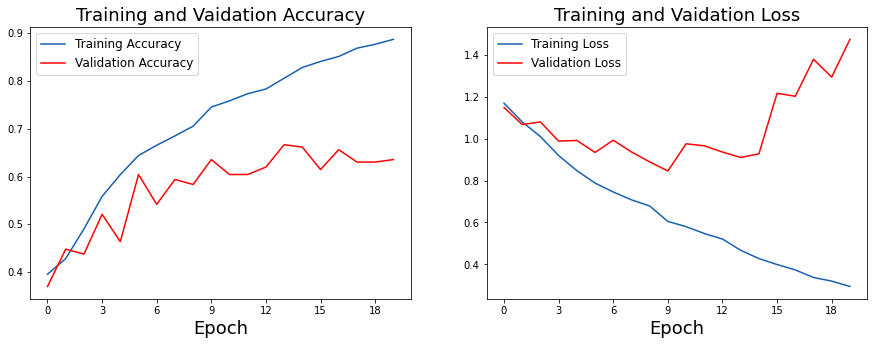

In [359]:
train_acc = history['Custom_3'].history['accuracy']
valid_acc = history['Custom_3'].history['val_accuracy']
train_loss = history['Custom_3'].history['loss']
valid_loss = history['Custom_3'].history['val_loss']

accuracy_loss_plotter('Custom_3', train_acc, valid_acc, train_loss, valid_loss)

Confusion matrix, without normalization


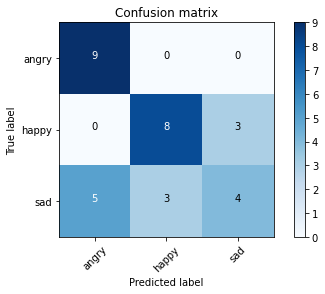

In [360]:
cm = cm_generator(model_custom_3, valid_ds, 1)
plot_cm(cm, label_to_class.keys())

Predicted as happy:


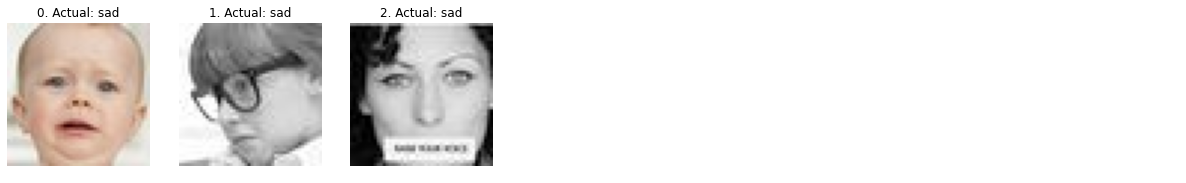

In [361]:
predicted='happy'
wrong_prediction_plotter(model_custom_3, valid_ds, predicted)

Predicted as sad:


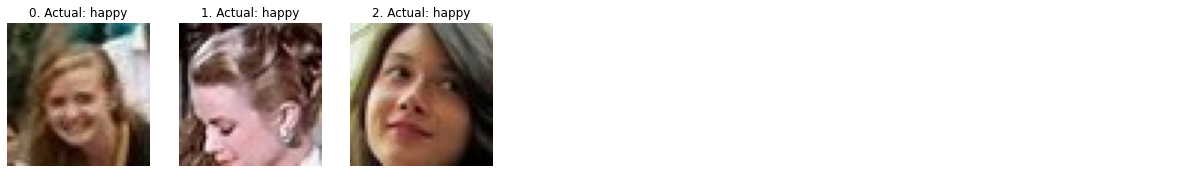

In [362]:
predicted='sad'
wrong_prediction_plotter(model_custom_3, valid_ds, predicted)

Predicted as angry:


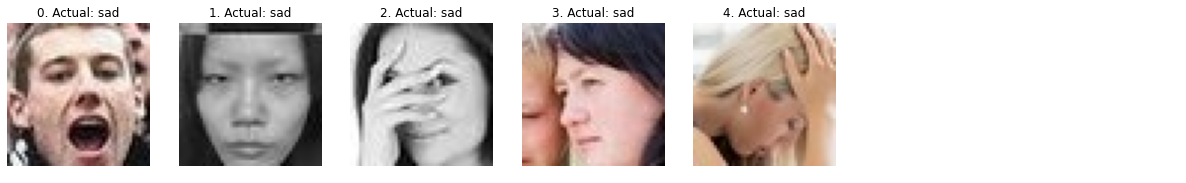

In [363]:
predicted='angry'
wrong_prediction_plotter(model_custom_3, valid_ds, predicted)

**Observations:**
- Retraining on the full epochs for the most optimum settings based on the keras tuner resulting in an improvement of slightly more than 1% from the original custom model 2. The best validation accuracy for Custom Model 3 is at 66.7%. 
- As the improvement is minimum, we need to further observe if the improvement is generalized to other dataset as minimum difference in model performance do happens from time to time due to the random nature of CNN.

## Summary of Model Training

Summary of facial expression detection models are as follows:

|  No. |   Model Name   |     Type     | Best Validation Accuracy | Remarks                                                     |
|:----:|:--------------:|:------------:|:------------------------:|-------------------------------------------------------------|
|  0.  |    Baseline    |      -       |           33.3%          | Select all data to be majority class                        |
|  1.  |      VGG16     |  Pre-trained |           63.5%          | Pretrained model                                            |
|  2.  |     VGGFace    |  Pre-trained |           75.5%          | VGG16 trained on facial dataset                             |
|  3.  |    ResNet50    |  Pre-trained |            50%           |                                                             |
|  4.  | Custom Model 1 | Custom Built |           34.9%          | Ended up categorizing all data into happy faces                        |
|  5.  | Custom Model 2 | Custom Built |           65.6%          | CNN with batch normalization                                |
|  6.  | Custom Model 3 | Custom Built |           66.7%          | Find best combination of hyperparameter using keras tuner.  |

**Observations:**
- The best model to identify emotion from facial expression is shown to be VGGFace with accuracy score almost 9% higher than the second best model. This is expected as VGGFace is trained on a [huge facial dataset](https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/) consisting of 2.6M pictures belonging to 2.6k distinct people. 
- All the three custom built model shared similar construction. However, the Custom Model 1 performs significantly worse than the rest as it suffers from exploding gradient problem. Custom Model 2 mitigates the issue by introducing batch normalization before activation layer for every convolution block. 
- Custom Model 3 performs slightly better than custom model 2. General performance comparison between the two model are to be confirmed further with more validation dataset. A more significant improvement on the accuracy may be achieveable through a combined random search over all hyperparameter instaed of splitting the search between convolution filters, dense unit and dropout values. 
- As ResNet50 and Custom Model 1 does not perform as well as the rest of the model, they will not be included on the model performance review chapter subsequently. 